# Group 16: Acid Rain Inside European Union

**GitHub Link**: https://github.com/pypr-2122/pp-project-2-group-16

**Environment**: +GeoPandas, +Descartes

**Notebook with All the Outputs Shown**: project-2-report-output.ipynb 

*This notebook does not show the output

## Table of Contents:

### [Functions](#1)
- Functions 1: Data Preparations
    - 1.1 [Request Data](#1.1)
        - [Request](#Request)     
          **Note**: If the data is not available, run this section to request the data (**Remove "#" before Requesting**).
    - 1.2 [Read Data from CSV](#1.2)
        - [Read](#Read)  
    - 1.3 [Aggregation](#1.3)
    - 1.4 [Map Function](#1.4)
    - 1.5 [Show Dataframes in Table](#1.5)
- Functions 2: Visualisation
    - 2.1 [European Union Map](#2.1)
    - 2.2 [Data Availability](#2.2)
    - 2.3 [Pollutants' Correlation](#2.3)
    - 2.4 [Yearly Pollutant Maps](#2.4)
    - 2.5 [Monthly / Weekly Changes](#2.5)
    - 2.6 [Daily Changes](#2.6)
    - 2.7 [Daily Distribution](#2.7)
    - 2.8 [Regional Daily Distribution](#2.8)
    - 2.9 [Hourly Distribution](#2.9)
    - 2.10 [Pollutant Spreading Maps](#2.10)
- Functions 3: Report
    - 3.1 [Violation Report](#3.1)
    
### [Acid Rain Inside European Union](#2)
- Intoduction to the Dataset
    - [Request Data from API](#R1.1)
    - [Getting Average](#R1.2)
    - [Data Availability](#R1.3)
    - [Relationship between Pollutants](#R1.4)
- Extent of the Violation on Pollutant Concentration
    - [Overview & Time Evaluation](#R2.1)
    - [Changes Over Time](#R2.2)
    - [Daily Observation](#R2.3)
    - [Estimating the Extreme](#R2.4)
    - [How the Pollutants Spread around the Capital City](#R2.5)
    - [In-details Report of Location Data](#R2.6)
    - [Conclusions](#R2.7)

<a id='1'></a>
# Functions

This section provides the collection of all function & package used to generate report in **Acid Rain Inside European Union** sections together with specifying the parameter to request and read data in [Request](#Request) and [Read](#Read).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import datetime
import requests

# GeoPandas is a package for spatial manipulation & visualisation
import geopandas
# Descartes is a package to support GeoPandas in doing spatial manipulation & visualisation
import descartes

# scipy.stats contains useful statistical function for this analysis
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

### Function 1: Data Preparations

<a id='1.1'></a>
#### Function 1.1:  Request Data

In [2]:
def write_data(pollutant_list, country_list, date_from, date_to): 
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function collects the data of air pollutant measurements and writes it into csv file based on the given air
    pollutants, countries, and period when the measurements are gathered. Also, writes down some information
    needed for the analysis, which consist of the pollutants, the countries, observed locations, and observed time.
    
    Input: pollutant_list, country_list, date_from, date_to
    ------------------------------------------------------------------------------------------------------------------
    pollutant_list (list) : containing dictionaries with 'parameter' as the key and name of the pollutant as the value.
    country_list (list)   : containing dictionaries with 'name' (name of the country),
                            'country' (country code), and 'capital' (capital city's name of the country) as the key.
    date_from (srting)    : with the format 'yyyy-mm-dd', represents the start date of the observed data.
    date_to (dtring)      : with the format 'yyyy-mm-dd', represents the end date of the observed data.
    '''
        
    # Since the api uses the UTC time to get the data, 
    # Then the function will make an adjustment to get it using the local time.
    
    # To begin with, this function will get more data by extending the period
    # By doing so, all the possibility of local time will be included in the extended period
    date_from = datetime.datetime.strptime(date_from, '%Y-%m-%d')+datetime.timedelta(days=-1)
    date_to = datetime.datetime.strptime(date_to, '%Y-%m-%d')+datetime.timedelta(days=1)
    
    # Set the local date to filter the data using the local time
    date_from_local = date_from+datetime.timedelta(days=1)
    date_to_local = date_to
    
    # Return the date into string format to be used for the API
    date_from = date_from.strftime('%Y-%m-%d')
    date_to = date_to.strftime('%Y-%m-%d')
    
    # Create an empty dictionary for keeping the location name
    location_list = {}
    
    # Start the loop to gather a spesific pollutant data
    for pollutant in pollutant_list:
        
        # Specify the location of the file based on the pollutant folder
        path = '{}'.format(pollutant['parameter'])

        # If such folder is not exist
        if not os.path.exists(path):
            
            # Create the folder
            os.makedirs(path)

        # Create an empty list for keeping the location name for the given pollutant
        location_list[pollutant['parameter']] = []
        
        # Start the loop to gather the countries data on a given pollutant
        for country in country_list:
            
            # Specify the parameter to gather the available location in the capital from api
            params_loc = {'limit' : 1000,
                          'parameter' : pollutant['parameter'],
                          'country' : country['country'],
                          'city' : country['capital']}
            
            # Get the data using the api
            loc = requests.get('https://docs.openaq.org/v2/locations?', params=params_loc)
            
            # If there is any available locations
            if loc.json()['results'] != []:
                
                # Change the data into dataframe and get the list of all the available locations
                location = pd.DataFrame(loc.json()['results'])
                location_name = list(location['name'].unique())
                
                # Set the empty dataframe for keeping the data of the country
                temp_country = pd.DataFrame()
                
                # Set the empty list, represents the location that doesn't have any data on the given period
                remove_list = []
                
                # Get the data for each available location 
                # The approach to get the data one-by-one in each locations is necessary to dealing with limit problem of the api
                for available_loc in location_name:
                
                # Set the parameter to get the main data on the given location
                    params_dict = {'date_from' : date_from,
                                   'date_to' : date_to,
                                   'limit' : 30000,
                                   'parameter' : pollutant['parameter'],
                                   'city' : country['capital'],
                                   'location' : available_loc}
                    
                    # Get the main data
                    measure = requests.get('https://docs.openaq.org/v2/measurements?', params=params_dict)
                    
                    # If there is any available data
                    if measure.json()['results'] != []:
                        
                        # Turn the data into dataframe
                        temp = pd.DataFrame(measure.json()['results'])
                        
                        # Get the local time and remove the last 6 characters which represent the offset from UTC
                        temp['date'] = pd.to_datetime(temp['date'].apply(lambda x: x['local'][:-6]))
                        
                        # Get the latitude and longitude of the location if available
                        temp['latitude'] = temp['coordinates'].apply(lambda x: x['latitude'] if x is not None else np.nan)
                        temp['longitude'] = temp['coordinates'].apply(lambda x: x['longitude'] if x is not None else np.nan)
                        
                        # Get the correct data for the given period using the local time
                        temp = temp.loc[(temp['date'] >= date_from_local) & (temp['date'] < date_to_local)]
                        
                        # Rename the column name for the pollutant
                        temp = temp.rename(columns={'parameter' : 'pollutant'})
                        
                        # Remove some unnecessary columns
                        temp = temp.drop(columns=['locationId', 'coordinates', 'isMobile', 'isAnalysis', 'entity', 'sensorType', 'unit', 'country', 'city'])
                        
                        # Add the location data into the country data
                        temp_country = temp_country.append(temp)  
                        
                    # If there is no available data
                    else:
                        # Add the location to be removed from the list later
                        remove_list.append(available_loc)
                    
                # Remove the location that has no data at all
                for remove_loc in remove_list:
                    location_name.remove(remove_loc)
                    
            # If the country doesn't have any available location
            else:
                # Set the empty list for the location
                location_name = []
                
            # Add all of the location in a country to the list of location based on the observed pollutant    
            location_list[pollutant['parameter']] += location_name
                
            # If there is any available location that has data    
            if location_name != []:
                # Write the file of that country data
                temp_country.to_csv('{}/{}.csv'.format(path, country['name']), index=False)
                
                # Notify that this function successfully write the country data on the observed pollutant
                print('Successfully Write : {}-{}'.format(pollutant['parameter'], country['name']))
                
        # Turn the data of the location into dataframe and change the column into key to make it easier to access for later
        location_list[pollutant['parameter']] = pd.DataFrame(location_list[pollutant['parameter']], columns=['key'])
    
    
    # If the folder where the information is kept is not available, then create it
    key_path = 'key_information'
    if not os.path.exists(key_path):
        os.makedirs(key_path)
    
    # Write all the pollutant's available location
    for pollutant in pollutant_list:
        location_list[pollutant['parameter']].to_csv('{}/location_{}.csv'.format(key_path, pollutant['parameter']), index=False)
        
    # Create the hourly, daily, weekly, monthly, and yearly date range from the given period and set the name of the columns as key
    hour = pd.DataFrame(pd.date_range(date_from_local, date_to_local, freq='H', closed='left', name='key'))
    hour['datetime'] = pd.to_datetime(hour['key'])

    date = pd.DataFrame(hour['key'].dt.date.unique(), columns=['key'])
    week = pd.DataFrame(hour['key'].dt.to_period('W').unique(), columns=['key'])
    month = pd.DataFrame(hour['key'].dt.to_period('M').unique(), columns=['key'])
    year = pd.DataFrame(hour['key'].dt.year.unique(), columns=['key'])
    
    # Turn the list of all country into dataframe as well as the list of all pollutant
    country_list = pd.DataFrame(country_list).rename(columns={'name' : 'key'})
    pollutant_list = pd.DataFrame(pollutant_list).rename(columns={'parameter' : 'key'})
    
    # Write all the neccessary information
    hour.to_csv('{}/datetime.csv'.format(key_path), index=False)
    date.to_csv('{}/date.csv'.format(key_path), index=False)
    week.to_csv('{}/week.csv'.format(key_path), index=False)
    month.to_csv('{}/month.csv'.format(key_path), index=False)
    year.to_csv('{}/year.csv'.format(key_path), index=False)
    country_list.to_csv('{}/country.csv'.format(key_path), index=False)
    pollutant_list.to_csv('{}/pollutant.csv'.format(key_path), index=False)

<a id='Request'></a>
#### Request Data

In [3]:
# Input of 'write_data'

# Specify the input of the pollutants that we are going to observe
pollutant_list = [{'parameter' : 'so2'},
                  {'parameter' : 'no2'}]

# Specify the input of the countries that we are going to observe
country_list = [{'name' : 'Austria', 'country' : 'AT', 'capital' : 'Wien'},
                {'name' : 'Belgium', 'country' : 'BE', 'capital' : 'Brussels-Capital Region'},
                {'name' : 'Bulgaria', 'country' : 'BG', 'capital' : 'София (столица)'},
                {'name' : 'Croatia', 'country' : 'HR', 'capital' : 'Grad Zagreb'},
                {'name' : 'Cyprus', 'country' : 'CY', 'capital' : 'Λευκωσία'},
                {'name' : 'Czechia', 'country' : 'CZ', 'capital' : 'Hlavní město Praha'},
                {'name' : 'Denmark', 'country' : 'DK', 'capital' : 'Hovedstaden'},
                {'name' : 'Estonia', 'country' : 'EE', 'capital' : 'Harjumaa'},
                {'name' : 'Finland', 'country' : 'FI', 'capital' : 'Uusimaa'},
                {'name' : 'France', 'country' : 'FR', 'capital' : 'Paris'},
                {'name' : 'Germany', 'country' : 'DE', 'capital' : 'Berlin'},
                {'name' : 'Greece', 'country' : 'GR', 'capital' : 'ΑΤΤΙΚΗ'},
                {'name' : 'Hungary', 'country' : 'HU', 'capital' : 'Budapest'},
                {'name' : 'Ireland', 'country' : 'IE', 'capital' : 'Dublin City'},
                {'name' : 'Italy', 'country' : 'IT', 'capital' : 'Roma'},
                {'name' : 'Latvia', 'country' : 'LV', 'capital' : 'Riga'},
                {'name' : 'Lithuania', 'country' : 'LT', 'capital' : 'Vilnius'},
                {'name' : 'Luxembourg', 'country':'LU', 'capital' : 'Luxemburg'},
                # for Malta, the capital city is not available, so we chose the city nearest to the capital
                {'name' : 'Malta', 'country' : 'MT', 'capital' : 'Msida'}, 
                {'name' : 'Netherlands', 'country' : 'NL', 'capital' : 'Amsterdam'},
                {'name' : 'Poland', 'country' : 'PL', 'capital' : 'Warszawa'},
                {'name' : 'Portugal', 'country' : 'PT', 'capital' : 'Lisboa'},
                {'name' : 'Romania', 'country' : 'RO', 'capital' : 'Bucureşti'},
                {'name' : 'Slovakia', 'country' : 'SK', 'capital' : 'Prešovský kraj'},
                {'name' : 'Slovenia', 'country' : 'SI', 'capital' : 'LJ Bežigrad'},
                {'name' : 'Spain', 'country' : 'ES', 'capital' : 'Madrid'},
                {'name' : 'Sweden', 'country' : 'SE', 'capital' : 'Stockholm'}]

# Specify the period
date_from = '2018-01-01'
date_to = '2020-12-31'


# # Run the function to write data into CSV
# -----remove # to request------
# write_data(pollutant_list, country_list, date_from, date_to)

<a id='1.2'></a>
#### Function 1.2: Read Data from CSV

In [4]:
def read_key(key_path = 'key_information'):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function reads all of the key information or the necessary information from key_information folder that will
    be used for analysing the countries, and gives the output in dictionary.
    
    Input: key_path
    ------------------------------------------------------------------------------------------------------------------
    key_path (string) : denotes the folder name where the information are stored.
    
    Output: key
    ------------------------------------------------------------------------------------------------------------------
    key (dictionary) : containing all of the necessary information. 
    'datetime'    : the hourly time range
    'date'        : the daily time range
    'week'        : the weekly time range
    'month'       : the monthly time range
    'year'        : the yearly time range
    'pollutant'   : the pollutants
    'country'     : the name of the countries
    'location_XX' : the available locations for XX pollutant (XX is either no2 or so2 in this analysis)
    '''

    # Set the empty dictionary for storing the information
    key = {}
    
    # If the folder exist
    if os.path.exists(key_path):
        
        # Get all information for the analysis
        for name in ['datetime', 'date', 'week', 'month', 'year', 'pollutant', 'country']:
            key[name] = list(pd.read_csv('{}/{}.csv'.format(key_path, name))['key'])
        for pollutant in key['pollutant']:
            key['location_{}'.format(pollutant)] = list(pd.read_csv('{}/{}.csv'.format(key_path, 'location_{}'.format(pollutant)))['key'])
    
    return key

def read_data(key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function reads the main data which contains all the countries and all the pollutant and gives the output in 
    dataframe. Also, remove all the negative measurements of the data. 
    
    Input: key
    ------------------------------------------------------------------------------------------------------------------
    key (dictionary) : denotes the necessary information to access the data, use the read_key function to get this 
    dictionary.
    
    Output: df
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe) : represents the main data for the analysis.
    '''
    
    # Set an empty dataframe
    df = pd.DataFrame()
    
    # Start the loop to get the data in every pollutant and country folders
    for pollutant in key['pollutant']:
        
        # Specify the folder location
        path = '{}'.format(pollutant)
        for country in key['country']:
            
            # If the folder is available
            if os.path.exists(path):
                
                # Try to get the data if there is a file on the folder
                try:
                    # Read the data
                    temp = pd.read_csv('{}/{}.csv'.format(path, country))
                    
                    # Remove the negative measurement
                    temp = temp.loc[temp['value']>=0]
                    
                    # Add an extra column represents the country name
                    temp['country'] = country
                    
                    # Add to the main dataframe
                    df = df.append(temp)
                except:
                    pass
    
    # Set the column name of hourly data to datetime
    df = df.reset_index(drop=True).rename(columns={'date' : 'datetime'})
    
    # Change the type of the time data
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Get some extra columns represent the time (date, week, month, and year)
    df['date'] = df['datetime'].dt.date
    df['week'] = df['datetime'].dt.to_period('W').astype(str)
    df['month'] = df['datetime'].dt.to_period('M').astype(str)
    df['year'] = df['datetime'].dt.year
    
    # Return the output
    return df

<a id='Read'></a>
#### Read Data

In [5]:
# Get the important information for analysis using the function read_key()
key = read_key()

# Get the main data for analysis
df = read_data(key=key)

<a id='1.3'></a>
#### Function 1.3: Aggregation

In [6]:
def get_data(df, loc, time, add_na=True, add_coordinates=False, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function turns the given dataframe (usually, the main data) into a new dataframe that is the average value
    of a given area and time. Also, this function can add missing observations as nan and add the coordinates that
    represents the area.
    
    Input: df, loc, time, add_na=True, add_coordinates=False, key=key
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe)   : represents data that will be averaged in the format of the main dataframe as in read_data function.
    loc (string)     : represents the observation area that will be averaged. Either 'location' or 'country'.
    time (string)    : represents the time that will be averaged. Either 'datetime' (hourly), 'date' (daily),
                       'week' (weekly), 'month' (monthly), or 'year' (yearly).
    add_na (boolean) : set whether the output dataframe will consist of the missing observation with the value as nan
                       add_coordinates (boolean) : set whether the output will be including the coordinate that represent the area
    key (dictionary) : denotes the necessary information to access the data, use the read_key function 
                       to get this dictionary.
    
    Output: agg_df
    ------------------------------------------------------------------------------------------------------------------
    agg_df (dataframe) : represents the result of averaging the data on the given time and area.
    '''
    
    # Set the temporary dataframe as the copy of the input dataframe
    temp = df.copy()
    
    # Set the date (datetime variable) as a string because all of the possible combinations having date as a string
    if time == 'date':
        temp['date'] = temp['date'].astype(str)
        
    # Calculate the average for each area and time
    agg_df = temp.groupby(['pollutant', loc, time])['value'].mean()
    
    # If the output will consist of the missing observation as nan
    if add_na:
        
        # Create all the possible combination of pollutant, location, and time based on the key
        if loc == 'location':
            index = [(i, j, k) for i in key['pollutant'] for j in key['location_{}'.format(i)] for k in key[time]]
        else:
            index = [(i, j, k) for i in key['pollutant'] for j in key[loc] for k in key[time]]
        
        # Reindex the dataframe, if the observation is not available then it will add that observation as nan for the value
        agg_df = agg_df.reindex(index)
        
    # Reset the index, so the dataframe appears in the same format  
    agg_df = agg_df.reset_index()
    
    # Return the format for date
    if time == 'date':
        agg_df['date'] = pd.to_datetime(agg_df['date'])
    
    # For additional information when averaging the location, add the country name into the output as well
    if loc == 'location':
        cnt_df = temp.groupby(['country', loc]).size().reset_index(name='size').drop(columns=['size'])
        agg_df = pd.merge(agg_df, cnt_df, how='left', on=loc)
    
    # If the output will consist of the coordinate
    if add_coordinates:
        # Get the coordinate that represent the area using the average of latitude and longitude
        coor_df = temp.groupby([loc])[['latitude', 'longitude']].mean().reset_index()
        
        # Join the coordinate information with the output dataframe
        agg_df = pd.merge(agg_df, coor_df, how='left', on=loc)
        
    # return the output
    return agg_df

<a id='1.4'></a>
#### Function 1.4: Map Function

In [7]:
def get_map(key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function returns GeoDataFrame, containing all of the countries inside the input dictionary (key).
    GeoDataFrame is an essential type of data to plot the map.
    
    Input: key
    ------------------------------------------------------------------------------------------------------------------
    key (dictionary) : denotes the necessary information to access the data, use the read_key function 
    to get this dictionary.
    
    Output: w_map
    ------------------------------------------------------------------------------------------------------------------
    w_map (geodataframe) : containing all the geographical information to visualise the countries
    '''
    
    # Get the data of all countries in the world using geopandas from naturalearth_lowres
    w_map = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    
    # Filter only the country available in the input dictionary (key)
    w_map = w_map.loc[w_map['name'].isin(key['country'])]
    
    # Get only the important column (name and geometry attribute of the country), rename for consistency
    w_map = w_map[['name', 'geometry']].reset_index(drop=True).rename(columns={'name' : 'country'})
    return w_map

<a id='1.5'></a>
#### Function 1.5: Show Dataframes in Table

In [8]:
def table(df, title, n_row = 20):
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    For 3 data frames used in our report, df, so2_result and no2_result, show a table with default number of rows of them
    
    Input: df, title, n_row
    ------------------------------------------------------------------------------------------------------------------
    df (data frame) : this function is only available for 3 data frames used in analysis (df, so2_result, no2_result)
    title (str)     : give the title of the table that will be displayed
    n_row (int)     : give a default number of rows that we want to show from the table
                      for the data frame, if n_row is an odd number, table will show (n-1)/2 rows of 'NO2' and 'SO2'
    '''
    
    # create an indicator to check which data frame is input
    # for 'df', pollutant has value of 'SO2' and 'NO2'
    # for 'so2_result' or 'no2_result', pollutant only has value of 'SO2' or 'NO2'
    
    indicator = df['pollutant'].unique()
    
    # if the data frame is 'df'
    if len(indicator) == 2:
        # we would like to display the first n_row/2 rows of SO2 and first n_row/2 rows of NO2
        # round all numbers in data frame to 2 decimal place
        df_table = pd.concat([df.loc[df['pollutant'] == 'so2'].head(int(n_row/2)), 
                              df.loc[df['pollutant'] == 'no2'].head(int(n_row/2))]).round(2)
        
        # update the columns names with the first letter in capital
        df_table.columns = [column[0].upper() + column[1:] for column in df_table.columns]
        
        # set the width of each column
        colWidths = [0.1, 0.08, 0.08, 0.15, 0.08, 0.08, 0.1, 0.11, 0.16, 0.1, 0.1]
        
        # set color for columns
        colcolors = 'darkseagreen'
        
    # if the data frame is 'so2_result' or 'no2_result'
    else:
        # we would like to display the first default number of  rows of so2_result or no2_result
        # round all numbers in data frame to 2 decimal place
        df_table = df.head(n_row).round(2)
        
        # delete the columns of pollutant
        df_table = df_table.drop(columns=['pollutant'])
        
        # update the columns names
        df_table.columns = ['Country', 'Location', 'Yearly Violation', 'Daily Violation', 'Hourly Violation']
        
        # set the width of each column
        colWidths = [0.1, 0.2, 0.12, 0.13, 0.13]
        
        # set color for columns
        colcolors = '#FF8FA3'
        
        # if the data frame is no2_result'
        if 'no2' in indicator:
            
            # we further delete the columns 'Daily Violation', because EEA doesn't specify the daily limit concentration for NO2
            df_table = df_table.drop(columns=['Daily Violation'])
            
            # update the width of columns
            colWidths = [0.1, 0.2, 0.12, 0.13] 
            
            # set color for columns
            colcolors = '#74C69D'
        
    # start to plot
    fig, ax = plt.subplots(1,1)
    
    # remove all axis
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    
    # set the title
    ax.set_title(title, fontweight ='bold', fontsize=20)        
    
    # draw the table
    table = ax.table(cellText = df_table.values, colLabels=df_table.columns,
                     colWidths = colWidths, 
                     colColours = [colcolors]*11, # set the background color of the header
                     loc = 8, cellLoc = 'center', rowLoc = 'center') # set the location of the whole table and text in cell
    
    table.auto_set_font_size(False) # discard auto font size
    table.set_fontsize(17) # reset the fontsize of text
    
    table.scale(4,2) # adjust width and height of the table
    
    plt.show()

### Function 2: Visualisation

<a id='2.1'></a>
#### Function 2.1 European Union Map

In [9]:
def map_decoration():
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function plots a map specifying the region of European Union Countries along with country's name.
    '''
    
    # Get the map
    w_map = get_map()
    
    # Get the coordinates for each country
    w_map['coords'] = w_map['geometry'].apply(lambda x: x.representative_point().coords[:][0])

    # Specify the region for each country
    w_map['area'] = np.nan
    
    country_area = {'Northern' : ['Sweden', 'Denmark', 'Finland', 'Ireland', 'Lithuania', 'Latvia', 'Estonia'],
                    'Eastern' : ['Poland', 'Romania', 'Czechia', 'Hungary', 'Bulgaria', 'Slovakia'],
                    'Western' : ['Germany', 'France', 'Netherlands', 'Belgium', 'Austria', 'Luxembourg'],
                    'Southern' : ['Italy', 'Spain', 'Greece', 'Portugal', 'Croatia', 'Slovenia', 'Malta']}
    
    for area in ['Northern', 'Eastern', 'Western', 'Southern']:
        w_map.loc[w_map['country'].isin(country_area[area]), 'area'] = area

    # Create the boundary area where we want to observe the map
    x_lim_start = -15
    x_lim_end = 35
    y_lim_start = 30
    y_lim_end = 75

    # Specify the color for region
    cmap = matplotlib.colors.ListedColormap(['#2A9D8F', '#E9C46A', '#F4A261', '#E76F51'])
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(30,30))
    
    # Plot the map
    w_map.plot(ax=ax, column='area', legend=True, legend_kwds={'markerscale' : 3, 'loc' : 'upper left', 'fontsize' : 24}, edgecolor='black', cmap=cmap, missing_kwds={'label' : 'Cyprus is Asia', 'color' : 'LightGrey', 'edgecolor' : 'black'})

    # Annotate the country's name
    for country in w_map['country'].unique():
        ax.annotate(text=country, xy=w_map.loc[w_map['country'] == country, 'coords'].values[0], fontsize=24, ha='center', va='center')

    # Set the xy-limit of the plot
    ax.set_xlim([x_lim_start, x_lim_end])
    ax.set_ylim([y_lim_start, y_lim_end])

    # Set the aspect ratio, so that the map isn't squeezed
    ax.set_aspect((x_lim_start-x_lim_end)/(y_lim_start-y_lim_end))

    # Remove the spines and ticks for xy-axis
    for position in ['left', 'top', 'right', 'bottom']:
        ax.spines[position].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set title
    plt.title('European Union Region Classification', fontsize=32)
    plt.show()


<a id='2.2'></a>
#### Function 2.2: Data Availability

In [10]:
def plot_data_availability(df=df, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function plots a visualisation which shows when the contries started to collect the data at their capital city.
    In addition, countries that don't have any data will be placed at the end of the period.
    
    Input: df, key
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe)   : represents the main data for the analysis.
    key (dictionary) : denotes the necessary information to access the data, use the read_key function to get this 
    dictionary.
    '''
    
    # Assign the dictionary for specifying the color of the visualisation and the name for the pollutant
    param = {'so2' : {'color' : '#C9184A', 'name' : '$SO_2$'}, 'no2' : {'color' : '#2D6A4F', 'name' : '$NO_2$'}}
    
    # Use get_data to get the average value in every country and month. However, the value itself will not be used.
    # The use of get_data is to get the unique combination of (pollutant, country, month) and also to get the data
    # of the country that is not available as nan (using add_na=True)
    temp = get_data(df, 'country', 'month')
    
    # Create a group based on the pollutant and country
    temp = temp.groupby(['pollutant', 'country'])
    
    # Get the minimum month for every country and pollutant where the value is available. In case no data available, assign the
    # end of the period.
    temp = temp.apply(lambda x: x.loc[~x['value'].isna(),'month'].min() if x['value'].isna().sum() != len(x) else key['month'][-1]).reset_index(name='month')
    
    
    # Start loop to create the loop for every pollutant
    for pollutant in key['pollutant']:
        
        # Create the temporary dataframe of temp that only consist the data from spesific pollutant, sort it based on the month
        temp_pol = temp.loc[temp['pollutant'] == pollutant].sort_values('month', ascending=False)
        
        # Create the new variable that will be used to create a line. This variable represents the height of the line
        # Country with the oldest month will be assigned with the highest height
        temp_pol['line_height'] = [(i+15) for i in range(len(temp_pol))]
        
        # Set the maximum limit for y axis to be the maximum height of the lines+1
        max_y_lim = temp_pol['line_height'].max()+1
        
        # Group the country based on its first available month, and get the list of the countries and its line height
        temp_pol = temp_pol.groupby('month')[['country', 'line_height']].agg(list)
        
        # Set the index to be datetime type
        temp_pol.index = pd.to_datetime(temp_pol.index) 

        # Set the indicator for the location of the line
        up = True
        
        # Set the indicator for the location of the text
        left = True
        
        # Set the X-axis limit which is the first and last month
        date_min = datetime.datetime.strptime(key['month'][0], '%Y-%m')
        date_max = datetime.datetime.strptime(key['month'][-1], '%Y-%m')

        # Create the subplot
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Create the horizontal line on the midle of the plot
        ax.hlines(y=0, xmin=date_min, xmax=date_max, color='black', linewidth=3)
        
        # Create the scatter plot denotes the available month group
        ax.plot(temp_pol.index, [0]*len(temp_pol.index), '-o', color='black', markerfacecolor='white')

        # Start the loop to draw the line and give the text to every month group
        for month in temp_pol.index:
            
            # If the location of the line is above the horizontal line
            if up:
                
                # Set the line's height with the maximum available height on the group
                ymax = max(temp_pol.loc[month, 'line_height'])
                
                # set the vertical allignment for month text
                va = 'top'
                
                # set the text offset for month text
                y_offset = -10
                
                # change the indicator so the next line will be under the horizontal line
                up = False
                
            # If the location of the line is under the horizontal line
            else:
                
                # Set the line's height with the  negative maximum available height on the group
                ymax = -max(temp_pol.loc[month, 'line_height'])
                
                # set the vertical allignment for month text
                va = 'bottom'
                
                # set the text offset for month text
                y_offset = 10
                
                # change the indicator so the next line will be above the horizontal line
                up = True
            
            # If the month is the last month in a period, then it means the data is not available,
            # specify some parameters to make it different
            if month == date_max:
                text = '(Data not Available)'
                color = 'gray'
            else:
                text = month.strftime('%b %y')

            # Create the vertical line based on the parameter
            ax.vlines(month, ymin=0, ymax=ymax, color=param[pollutant]['color'], linewidth=3)
            
            # Annotate the month for that line
            ax.annotate(text, xy=(month, 0), xytext=(0, y_offset), textcoords='offset points', rotation=90, fontsize='x-large', va=va, ha='center')
            
            # Prepare the loop to give the text of the country's name
            for country, height in zip(temp_pol.loc[month, 'country'], temp_pol.loc[month, 'line_height']):
                
                # If the line is under the horizontal line, then up=True right now
                if up:
                    
                    # Assign the coordinate of the text to be below the horizontal line
                    height *= -1
                    
                # Set some parameter based on the location of the text (left/right) also change it for the next text
                if left:
                    ha = 'left'
                    x_offset = 3
                    left = False
                else:
                    ha = 'right'
                    x_offset = -3
                    left = True
                    
                # Give the text using annotate
                ax.annotate(country, xy=(month, height), xytext=(x_offset,0), textcoords='offset points', fontsize='large', va=va, ha=ha)

        # Set the x-limit, add +-8 weeks for giving space to the text
        ax.set_xlim(date_min-datetime.timedelta(weeks=8), date_max+datetime.timedelta(weeks=8))
        
        # Set the y-limit
        ax.set_ylim(-max_y_lim, max_y_lim)

        # Create minor tick in month 4,7, and 10
        format_month = matplotlib.dates.MonthLocator(bymonth=[4,7,10])
        
        # Create major tick in every year
        format_year = matplotlib.dates.YearLocator()
        
        # Set the major and minor tick, also specify the format
        ax.xaxis.set_minor_locator(format_month)
        ax.xaxis.set_major_locator(format_year)
        ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
        ax.tick_params(axis='x', which='major', length=12, labelsize=12)
        ax.tick_params(axis='x', which='minor', length=8, labelsize=8)
        ax.tick_params(axis='y', which='both', labelleft=False, left=False)
        
        # Give label for x-axis
        ax.set_xlabel('Time Period', fontsize='xx-large')

        # Remove the spines of the plot, except the bottom one
        for position in ['left', 'top', 'right']:
            ax.spines[position].set_visible(False)
            
        # Give the title for the plot
        plt.title('Data Availability of {} for EU Countries'.format(param[pollutant]['name']), fontsize='xx-large')
        plt.show()
        
        # Prepare an extra space for the next plot
        print('\n')

<a id='2.3'></a>
#### Function 2.3: Pollutants' Correlation

In [11]:
def Relationship_Pollutant():
    
    '''
    Description: 
    -----------------------------------------------------------------------------
    In this function, we are plotting the scatter plot to illustrate the relationship of the 
    pollutant SO2 and pollutant CO2, the data used to plot the graph is contributed by the 
    monthly data for each year. Also the correlation coefficient is shown on the title of each
    plot. The colorbar shows the concentration of the pollutant, the darker the color, the worse
    the pollutant.
    '''
    
    fig, ax = plt.subplots(1,3, figsize = (24,8), sharey = True, sharex = True)

    # Specify color map
    reversed_color_map = matplotlib.cm.get_cmap('gist_gray_r')

    df_year = {}
    k = 0
    im = {}
    
    for year in key['year']:

        # Get the monthly data in each year
        df_year[year] = get_data(df.loc[df['year'] == year], 'country', 'month', add_na=False)
        temp = df_year[year].copy()

        # Sort out the data
        temp_group = temp.groupby(['country', 'month'])['pollutant'].nunique()
        index = temp_group.loc[temp_group == 2].index
        temp = temp.set_index(['country', 'month'])
        temp = temp.loc[temp.index.isin(index)].reset_index()
        temp = temp.sort_values('pollutant').groupby(['country', 'month'])

        # Get the data for no2 and so2
        no2 = temp['value'].first().values
        so2 = temp['value'].last().values

        # Since the values of the so2 and no2 data have a big scale difference, therefore, we want to normalise the data in (0,1)
        norm_no2 = (no2-np.min(no2))/(np.max(no2)-np.min(no2))
        norm_so2 = (so2-np.min(so2))/(np.max(so2)-np.min(so2))

        # Get the mean value of the normalised so2 and no2 data 
        mean = np.mean(np.array([norm_no2, norm_so2]).T, axis=1)

        # Make the scatter plot
        im[year] = ax[k].scatter(so2, no2, c = mean, cmap= reversed_color_map, vmin=0, vmax=1)

        # Get the correlations:
        cor = round(np.corrcoef(so2, no2)[0,1], 2)

        # Set up the x and y labels:
        ax[k].set_xlabel('$SO_2$ \n $\mu g/m^3$', fontsize = 20)
        ax[k].set_ylabel('$NO_2$ \n $\mu g/m^3$', fontsize = 20)
            
            # Change the size of the label
        ax[k].tick_params(axis='both', which = 'major', labelsize = 20)
        
        # Set up the grid of the plot
        ax[k].grid()
        
        # Set up the title
        ax[k].set_title('Year {}, Correlation: {}'.format(year, cor), fontsize = 20)
        
        
        k +=  1

    # Make the colorbar
    norm = matplotlib.colors.Normalize(vmin = 0, vmax = 1)
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=reversed_color_map), aspect=40, orientation="horizontal", ax=ax[:], pad = 100)
    cbar.ax.tick_params(labelsize=20)

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0.4)

    plt.show()

<a id='2.4'></a>
#### Function 2.4: Yearly Pollutant Maps

In [12]:
def plot_map(df=df, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function visualises the map of European Union along with its average pollutant concentration
    over 3 years period.
    
    Input: df, key
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe)   : represents the main data for the analysis.
    key (dictionary) : denotes the necessary information to access the data, use the read_key function 
    to get this dictionary.
    '''

    # Get the average for each country in every year, also get the coordinates representation
    temp = get_data(df, 'country', 'year', add_coordinates=True)
    
    # Get the map geodataframe
    w_map = get_map()

    # Create the boundary area where we want to observe the map
    x_lim_start = -15
    x_lim_end = 35
    y_lim_start = 30
    y_lim_end = 75

    # Set the subplots (3 cols: 3 years, 2 rows: 2 pollutants)
    fig, ax = fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(30, 20))

    # Set the parameter for each pollutant, cmap: color map, bound: list consists of numbers where the color change
    param = {'so2' : {'cmap' : matplotlib.colors.ListedColormap(['#FFF0F3', '#FF8FA3', '#C9184A', '#590D22', 'black']),
                      'bound' : [0, 5, 10, 15, 20, 25], 'label' : '${SO_2}$ Concentration\n${\mu}g/m^3$',
                      'value' : 20},
             'no2' : {'cmap' : matplotlib.colors.ListedColormap(['#D8F3DC', '#74C69D', '#2D6A4F', '#1B4332', 'black']),
                      'bound' : [0, 10, 20, 30, 40, 50], 'label' : '${NO_2}$ Concentration\n${\mu}g/m^3$',
                      'value' : 40}}
    
    # Create the legend
    grey_patch = matplotlib.lines.Line2D([],[], marker='s', markersize=12, color='LightGrey', linestyle='None', label='Not Available')

    # Iterate to create every map
    row = 0
    for pollutant in key['pollutant']:
        col = 0
        
        # Create the boundary where the color from cmap should change
        norm = matplotlib.colors.BoundaryNorm(param[pollutant]['bound'], param[pollutant]['cmap'].N)
        for year in key['year']:
            
            # Filter to get the data of the given year and pollutant
            temp_pollutant = temp.loc[(temp['pollutant'] == pollutant) & (temp['year'] == year)]
            
            # Combine the average value to the world map geodataframe
            temp_map = pd.merge(w_map, temp_pollutant, on='country', how='left')
            
            # Filter countries that has violated the yearly concentration
            temp_violation = temp_map.loc[temp_map['value'] > param[pollutant]['value']]

            # Create the map, give the color according to the value, also set the color of country that doesn't have data
            temp_map.plot(ax = ax[row][col], column='value', edgecolor='black', cmap=param[pollutant]['cmap'], norm=norm, missing_kwds={'color' : 'LightGrey', 'edgecolor' : 'black'})

            # Give annotation to country that has surprassed the yearly concentration
            for country in list(temp_violation['country']):
                temp_country = temp_violation.loc[temp_violation['country'] == country]
                text = '{}'.format(country)
                ax[row][col].annotate(text, xy=(temp_country['longitude'], temp_country['latitude']),
                                      xytext=(-30, 15), textcoords='offset points', fontsize=12, fontweight='bold', va='center', ha='center')

            # Set the xy-limit of the plot
            ax[row][col].set_xlim([x_lim_start, x_lim_end])
            ax[row][col].set_ylim([y_lim_start, y_lim_end])

            # Set the aspect ratio, so that the map isn't squeezed
            ax[row][col].set_aspect((x_lim_start-x_lim_end)/(y_lim_start-y_lim_end))

            # Remove the spines and ticks for xy-axis
            for position in ['left', 'top', 'right', 'bottom']:
                ax[row][col].spines[position].set_visible(False)

            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])

            # Set the year text
            ax[row][col].set_title('{}'.format(year), fontsize=24, fontweight='bold')

            # Set the legend to be appeared only on the first column of subplots
            if col == 0:
                ax[row][col].legend(handles=[grey_patch], loc='upper left', fontsize=16)

            col += 1

        # Create the main colorbar
        cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=param[pollutant]['cmap']), ax = ax[row][:], extend='max',
                                                  orientation='horizontal', pad = 0, aspect=40, shrink=0.75)
        # Set the title and style of the colorbar 
        cbar.set_label(label=param[pollutant]['label'], size=16)
        cbar.ax.tick_params(labelsize=16)
        
        row += 1

    # Create the main title        
    fig.suptitle('European Union Pollutants Map', fontsize=32)
    plt.show()


<a id='2.5'></a>
#### Function 2.5: Monthly / Weekly Changes

In [13]:
def plot_27_MonthWeek(df, pollutant, dim):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    plots monthly or weekly average changes of pollutant's value among 27 countries
    
    Input: df, pollutant, dim
    ------------------------------------------------------------------------------------------------------------------ 
    df (data frame) : the full data frame
    pollutant (str) : type of pollutant; N02 / SO2
    dim: (str)      : dimension of values; month / week
    '''
    
    # get the data frame for plotting
    # use the function 'get_data' to generate the data frame for plotting, based on dimension of data needed
    # df_plot is a date frame with the monthly or weekly mean values of each countries 
    if dim == 'month':
        df_plot = get_data(df, 'country', 'month', add_na=True)
    elif dim == 'week':
        df_plot = get_data(df, 'country', 'week', add_na=True)
    
    # creat figure with 4 subplots
    # there are 27 countries in total, so we will have 7 or 6 countries in each cubplots
    fig, ax = plt.subplots(4, 1, figsize=(19,20), sharex=True, gridspec_kw={'hspace': 0})
    
    # instead of ploting all countries in one graph, which is difficult for checking specific country
    # for each subplot, countries interested will have color and legend shown while the other countries will plot in gray
    # so that, it is easy to compare each country with all other countries
    # so there are 4 subplots in total, and we will plot all 27 countries in each subplot with countries in different colors
    for i in range(4):
        # mark the order of countries
        num = 0
        
        # creat an empty list to store the plot with color
        # this is used for adding legend only to countries with color
        lines = []
        
        # get the list of all countries and use a for-loop to plot each of them
        for country in df_plot['country'].unique():
            
            # mark the number of countries 
            num += 1
            
            # get the list of value for plotting, in terms of the type of pollutant and name of country
            x = df_plot.loc[df_plot['pollutant'] == pollutant.lower()]
            x = x.loc[x['country'] == country]
            
            # for the ith subplot, only 7 (or 6) countries with order from 1+i*7 to 8+i*7 will have color
            if num >= 1 + i*7 and num < 8 + i*7:
                lines += ax[i].plot(x[dim], x['value'], marker='', linewidth=1.2, alpha=0.9, label=country) 
            
            # for other countries, we set them all in light gray
            else:
                ax[i].plot(x[dim], x['value'], marker='', linewidth=1, alpha=0.6, label=country, color = 'lightgray') 
        
        # provide legend only for countries have color in respective subplot
        ax[i].legend(lines, df_plot['country'].unique()[i*7 : 7 + i*7], loc=2, ncol=7, fontsize=12)
        
        # set the y label
        ax[i].set_ylabel(ylabel = 'Value', fontsize=15) 
        
        # set the background as while
        ax[i].set_facecolor('white') 
        
        # creat horizontal grid line
        ax[i].grid(axis='y', c='black', alpha=0.3, linewidth=0.5, linestyle=':') 
        
        # spin the ticks by 45 degree
        ax[i].tick_params(labelrotation=45) 
        
        # remove the spines for all subplots
        ax[i].spines['bottom'].set_visible(False) 
    
    # add title    
    ax[0].set_title(f'{dim[0].upper()}{dim[1:]}ly Changes: ${pollutant[:2]}_2$') 
    
    # set the fontsize of title
    ax[0].title.set_size(16) 
    
    # set the x label
    ax[3].set_xlabel(xlabel = 'Time', fontsize=15) 
    
    # give back the spine for the last subplot
    ax[3].spines['bottom'].set_visible(True) 
    
    # for plot of weekly data, there are too many weeks 
    # show each 10 of them as the x ticks
    if dim == 'week':
        ax[3].set_xticks(df_plot['week'].unique()[::10]) 
    plt.show()

<a id='2.6'></a>
#### Function 2.6: Daily Changes

In [14]:
def plot_daily(df, pollutant, country):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    plots daily average changes of pollutant in a country
    
    Input: df, pollutant, dim
    ------------------------------------------------------------------------------------------------------------------ 
    df (data frame) : the full data frame
    pollutant (str) : type of pollutant; N02 / SO2
    country (str)   : name of country and the list is 
                      'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
                      'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungaray', 'Ireland', 
                      'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 
                      'Portugal','Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
                      (Slovenia doesn't have value for both NO2 and SO2, so the plots are empty)
    '''
    
    # create a figure with only 1 subplot
    # because we only need one plot and it is easy to use the function in subplot
    fig, ax = plt.subplots(1, 1, figsize=(19,5))
    
    # set the background in white
    ax.set_facecolor('white') 
    
    # generate the data for plotting
    # use function get_data to gain the daily average 
    df_plot = get_data(df, 'country', 'date', add_na=True)
    
    # select the part of NO2
    x = df_plot.loc[df_plot['pollutant'] == pollutant.lower()] 
    
    # get the list of value of the country
    x = x.loc[x['country'] == country] 
    
    # plot the values
    ax.plot(x['date'], x['value'], marker='', linewidth=1, alpha=1, label=country, color='darkgreen')
    
    # set the title
    ax.set_title(f'{country[0].upper()}{country[1:]}: ${pollutant[:2]}_2$ Daily Changes') 
    
    # set the size of title
    ax.title.set_size(16) 
    
    # use every 30 date as the ticks of x
    ax.set_xticks(df_plot['date'].unique()[::30]) 
    
    # spin ticks to avoid overlapping 
    ax.tick_params(labelrotation=45) 
    
    # set the x lable
    ax.set_xlabel(xlabel = 'Time', fontsize=15) 
    
    # set the y lable
    ax.set_ylabel(ylabel = 'Value', fontsize=15)
    
    # add horizontal grid lines
    ax.grid(axis='y', c='black', alpha=0.3, linewidth=0.5, linestyle=':') 
    
    plt.show()

<a id='2.7'></a>
#### Function 2.7: Daily Distribution

In [15]:
def plot_distribution(df=df, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function plot a visualisation which shows the daily distribution for each country along with the median.
    Also, this function shows the daily limit of SO2 based on European Environment Agency.
    
    Input: df, key
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe)   : represents the main data for the analysis.
    key (dictionary) : denotes the necessary information to access the data, use the read_key function to get this dictionary.
    '''
    
    # Assign the dictionary for specifying several parameters of the visualisation
    param = {'so2' : {'color' : np.array((201, 24, 74, 255))/255,'color_inside' : np.array((255, 143, 163, 1))/255, 'name' : '$SO_2$', 'limit' : 125, 'x_start' : -2.5, 'x_end' : 160, 'tick_minor' : matplotlib.ticker.MultipleLocator(5), 'tick_major' : matplotlib.ticker.MultipleLocator(20)},
             'no2' : {'color' : np.array((45, 106, 79, 255))/255, 'color_inside' : np.array((116, 198, 157, 1))/255, 'name' : '$NO_2$', 'limit' : np.nan, 'x_start' : -2.5, 'x_end' : 160, 'tick_minor' : matplotlib.ticker.MultipleLocator(5), 'tick_major' : matplotlib.ticker.MultipleLocator(20)}}
    
    # Get the daily average for each country, also add the not available data as nan
    temp = get_data(df, 'country', 'date')
    
    # Get the median daily average for each country, name the column as median
    median = temp.groupby(['pollutant', 'country'])['value'].quantile(0.5).reset_index(name='median')
    
    # Rounding the value into multiple of 4 so that the observation is not pile up
    temp['value'] = np.round(temp['value']/4)*4
    
    # Set the subplots for visualisation
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,16))
    
    # Specify the column index to denote the columns in the subplots
    col = 0
    
    # Start the loop to draw plots for each pollutant
    for pollutant in key['pollutant']:
        # Get the data for the given pollutant
        temp_pol = temp.loc[temp['pollutant'] == pollutant]
        
        # Get the median data for the given pollutant
        median_pol = median.loc[median['pollutant'] == pollutant]
        
        # Left join the data so the main dataframe (temp_pol) has the median value,
        # then the value is sorted in ascending order + set the missing value in the first position (it will apear in reverse order in the plot)
        temp_pol = pd.merge(temp_pol, median_pol, how='left', on='country').sort_values('median', na_position='first')
        
        # Create the scatter plot for the distribution of daily values
        ax[col].scatter(x=temp_pol['value'], y=temp_pol['country'], s=100, color=param[pollutant]['color_inside'], edgecolor=param[pollutant]['color'])
                
        # Create the scatter plot to denote the median of daily values
        ax[col].scatter(x=median_pol['median'], marker='d', y=median_pol['country'], s=100, color='black', edgecolor='black', alpha=1)
        
        # Create horizontal lines for the each country as decorations
        ax[col].hlines(y=key['country'], xmin=0, xmax=2*temp_pol['value'].max(), color='gray', alpha=0.25, linewidth=1, linestyles='dashdot')

        # If the daily limit is available
        if ~np.isnan(param[pollutant]['limit']):
            
            # Create a vertical line to show awareness of whether there is any observation that surprass the limit
            ax[col].vlines(x=param[pollutant]['limit'], ymin=0, ymax=len(key['country']), color='black', alpha=0.5, linewidth=1, linestyles='dashdot')
            
            # Annotate the meaning of the vertical line in the middle of the vertical line
            ax[col].annotate('Maximum Daily Average', xy=(param[pollutant]['limit'], len(key['country'])),
                              rotation=-90, fontsize='x-large', color='black', va='top', ha='left')
        
        # Remove the spines of the plot, except for the bottom one
        for position in ['left', 'top', 'right']:
            ax[col].spines[position].set_visible(False)
        
        # Set the limit of y-axis equal to the number of all of the country
        ax[col].set_ylim([-1, len(key['country'])+1])

        # Set the limit of x-axis to show a better plot
        ax[col].set_xlim([param[pollutant]['x_start'], param[pollutant]['x_end']])
        
        # Set the tick parameter for x-axis, both major and minor ticks
        ax[col].xaxis.set_minor_locator(param[pollutant]['tick_minor'])
        ax[col].xaxis.set_major_locator(param[pollutant]['tick_major'])
        ax[col].tick_params(axis='x', which='major', length=12, labelsize=12)
        ax[col].tick_params(axis='x', which='minor', length=8, labelsize=8)
        
        # Set the label of x-axis
        ax[col].set_xlabel('Concentration\n${\mu}g/m^3$')
        
        # Set the title for the plot
        ax[col].set_title('Distribution of Daily Average of {}'.format(param[pollutant]['name']), fontsize='x-large')
        
        # Create the legend
        patch = matplotlib.lines.Line2D([],[], marker='d', markersize=12, color='black', linestyle='None', label='Median')
        ax[col].legend(handles=[patch], loc='upper left', fontsize=16)

        col += 1

    # Show the subplots
    plt.tight_layout()
    plt.show()

<a id='2.8'></a>
#### Function 2.8: Regional Daily Distribution

In [16]:
def Distribution(area):
    
    '''
    Description:
    ---------------------------------------------------------------------
    The function is plotting the histogram of the data for the countries in different areas of the 
    Europe. The x axis is showing the concentration of the pollutant and y axis is showing the possibility
    of getting that amount of the concentration. 
    Also, the distribution line (Created by Kernel Density Estimation) has been drawn in the graph as well.
    All the graph will be shown if you input 'All', there is only one graph will be shown if you input the specific name of the area.
    
    Input: area
    ---------------------------------------------------------------------
    area (str) : 'Northern', 'Eastern', 'Western', 'Southern' or 'All', the region in the Europe.

    Output:
    ---------------------------------------------------------------------
    The histogram of the specific area or all areas.
    '''
    
    country_area = {'Northern' : ['Sweden', 'Denmark', 'Finland', 'Ireland', 'Lithuania', 'Latvia', 'Estonia'],
       'Eastern' : ['Poland', 'Romania', 'Czechia', 'Hungaray', 'Bulgaria', 'Slovakia'],
       'Western' : ['Germany', 'France', 'Netherlands', 'Belgium', 'Austria', 'Luxembourg'],
       'Southern' : ['Italy', 'Spain', 'Greece', 'Portugal', 'Croatia', 'Slovenia', 'Malta']}


    if area !=  'All':
        
        # area = country_northern/country_eastern/country_western/country_southern

        # Get data
        temp = get_data(df, 'country', 'date', add_na=False)

        temp_region = temp.loc[temp['country'].isin(country_area[area])]

        fig, ax = plt.subplots(1, 2, figsize = (17,6)) 

        fig.suptitle('Concentration of Pollutant in {} EU contries'.format(area), fontsize = 18)

        param = {'so2':{'xmax': 20, 'color':'#ca0147', 'bin':25}, 'no2':{'xmax':70, 'color':'#137e6d', 'bin':70}}
        col = 0

        for i in key['pollutant']:
            # Plot the histogram for so2 and no2:
            title = ['$SO_2$', '$NO_2$']

            # Get data
            temp1 = temp_region.loc[temp_region['pollutant'] == i, 'value']

            # Set the graph above the grid
            ax[col].set_axisbelow(True)
            ax[col].grid()

            # Create KDE line
            x = np.linspace(0, param[i]['xmax'], 101)
            f = stats.gaussian_kde(temp1, bw_method = 1/4)
            y = f(x)/f.integrate_box_1d(0, 1e6)
            ax[col].plot(x, y, color = 'black', linewidth = 1.3)

            # Make the histogram
            ax[col].hist(temp1, bins = np.linspace(0, param[i]['bin'], 35), alpha = 0.9, density = True, facecolor = param[i]['color'], edgecolor = 'black')
            ax[col].set_xlabel(f'Concentration of {title[col]}', fontsize = 16)
            ax[col].set_ylabel(f'Proportion', fontsize = 16)
            ax[col].set_title(f'{title[col]}', fontsize = 15)
            ax[col].tick_params(axis = 'y', labelleft = False)
            col += 1

        plt.show()
        
    else:

        # Get data
        temp = get_data(df, 'country', 'date', add_na=False)
        Area = ['Northern', 'Eastern', 'Western', 'Southern']
        index = 0

        # Create the histgrams and kde lines
        for region in list(country_area.keys()):
            temp_region = temp.loc[temp['country'].isin(country_area[region])]

            fig, ax = plt.subplots(1, 2, figsize = (17,6)) 
            
            fig.suptitle('Concentration of Pollutant in {} EU contries'.format(Area[index]), fontsize = 18)

            param = {'so2':{'xmax': 20, 'color':'#ca0147', 'bin':25}, 'no2':{'xmax':70, 'color':'#137e6d', 'bin':70}}
            col = 0

            for i in key['pollutant']:
                # Plot the histogram for so2 and no2:
                title = ['$SO_2$', '$NO_2$']

                # Get data
                temp1 = temp_region.loc[temp_region['pollutant'] == i, 'value']

                # Set the graph above the grid
                ax[col].set_axisbelow(True)
                ax[col].grid()

                # KDE line
                x = np.linspace(0, param[i]['xmax'], 101)
                f = stats.gaussian_kde(temp1, bw_method = 1/4)
                y = f(x)/f.integrate_box_1d(0, 1e6)
                ax[col].plot(x, y, color = 'black', linewidth = 1.3)

                # Make the histogram
                ax[col].hist(temp1, bins = np.linspace(0, param[i]['bin'], 35), alpha = 0.9, density = True, facecolor = param[i]['color'], edgecolor = 'black')
                ax[col].set_xlabel(f'Concentration of {title[col]}', fontsize = 16)
                ax[col].set_ylabel(f'Proportion', fontsize = 16)
                ax[col].set_title(f'{title[col]}', fontsize = 15)
                ax[col].tick_params(axis = 'y', labelleft = False)
                col += 1

            plt.show()
            index += 1

<a id='2.9'></a>
#### Function 2.9: Hourly Distribution

In [17]:
def plot_distribution_kde(df=df, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function visualises the hourly distribution for every country. The distribution are estimated using the
    Kernel Density Estimation (KDE), adjusted to be a bit more sensitive over the extreme values. Also, Calculate the
    probability that an hour concentration will surprass the hourly concentration limit and shows it in the visualisation
    
    Input: df, key
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe) : represents the main data for the analysis.
    key (dictionary) : denotes the necessary information to access the data, use the read_key function to get this dictionary.
    
    '''

    # Get the hourly average for every country, there is no need to get the missing value included
    temp = get_data(df, 'country', 'datetime', add_na=False)

    # Get the ourly data for every pollutant and country, keep it as an array
    temp = temp.groupby(['pollutant', 'country'])['value'].apply(np.array)

    # Set the subplots
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,16))

    # Set the parameter for each pollutant
    param = {'so2' : {'value' : 350, 'x_max' : 30, 'color_1' : '#FF8FA3' , 'color_2' : '#590D22', 'label' : '$SO_2$', 'major_tick' : matplotlib.ticker.MultipleLocator(2), 'minor_tick' : matplotlib.ticker.MultipleLocator(0.5)},
             'no2' : {'value' : 200, 'x_max' : 60, 'color_1' : '#74C69D' , 'color_2' : '#1B4332', 'label' : '$NO_2$', 'major_tick' : matplotlib.ticker.MultipleLocator(4), 'minor_tick' : matplotlib.ticker.MultipleLocator(1)}}

    # Create the index and empty dictionary for creating dataframe consists of information to draw the KDE
    index = 0
    data = {}
    
    # Start to get the information
    for pollutant in key['pollutant']:
        for country in key['country']:
            
            # Set empty dictionary 
            data[index] = {}
            
            # If the data available
            try:
                # Get the distribution estimation using gaussian kernel density estimation,
                # bw_method is a parameter which sets the sensitivity towards each observation (<1 means we consider extreme values more on the estimation)
                # The choice of 1/4 is based on subjectivity of our analysis on the resulted plot
                data[index]['kde'] = stats.gaussian_kde(temp.loc[(pollutant, country)], bw_method=1/4)
                
                # Set the median of the distribution
                data[index]['center'] = np.median(temp.loc[(pollutant, country)])
                
                # Create a partition to draw the pdf
                data[index]['x'] = np.linspace(0, param[pollutant]['x_max'], 1001)
                
                # Set the pdf estimation for every x
                data[index]['y'] = data[index]['kde'](data[index]['x'])
                
                # Set the pollutant and country name
                data[index]['pollutant'] = pollutant
                data[index]['country'] = country

                # Calculate the probability that an hour measurement will surprass the hourly concentration limit
                # Also, make an adjustment by dividing the result by the probability that the measurement taking non-negative value
                data[index]['extreme_prob'] = data[index]['kde'].integrate_box_1d(param[pollutant]['value'], np.inf)/data[index]['kde'].integrate_box_1d(0, 1e6)

            # When the data is not available, only get the data for the name of the country and the pollutant
            except KeyError:
                data[index]['pollutant'] = pollutant
                data[index]['country'] = country
            index += 1

    # Turn the dictionary into dataframe
    data = pd.DataFrame(data).T

    # Start to draw the distribution 
    col = 0
    for pollutant in key['pollutant']:
        
        # Given the pollutant, sort the country based on the probability then the median. Not available country will apear last
        # (but we use na_position=first for this, since we are using the horizontal orientation)
        temp_pol = data.loc[data['pollutant'] == pollutant].sort_values(['extreme_prob', 'center'], na_position='first').reset_index(drop=True)
        
        # Adjust the the size of the pdf, it is important to get the shape of the distribution and compare it
        # 1.75 is the best scale to show the distribution
        temp_pol['y'] = temp_pol.apply(lambda x: 1.75*(x['y']-x['y'].min())/(x['y'].max()-x['y'].min()) if ~np.isnan(x['y']).all() else np.nan, axis=1) + temp_pol.index

        # Create the horizontal line for each country
        ax[col].hlines(y=temp_pol['country'], xmin=0, xmax=param[pollutant]['x_max'], alpha=0.5, color='black', linewidth=1)
        
        # Set the indicator to change the color every iteration later
        color_indicator = True

        # Start drawing the distribution but in reversed order so it will overlap nicely
        for country in reversed(list(temp_pol['country'])):
            
            # Get only the given country data
            temp_country = temp_pol.loc[(temp_pol['country'] == country)]
            
            # Try drawing for the available country
            try:
                
                # Actively change the color of the plot for every iteration
                if color_indicator:
                    color = param[pollutant]['color_1']
                    color_indicator = False
                else:
                    color = param[pollutant]['color_2']
                    color_indicator = True

                # Create the visualisation of the country distribution
                ax[col].fill_between(temp_country['x'].values[0], temp_country['y'].values[0], temp_country.index[0], alpha=0.5, color=color, edgecolor='black', linewidth=1)

                # Show the probability in custom format
                if ~np.isnan(temp_country['extreme_prob'].values[0]):
                    
                    # If the probability is not zero, we will create the custom format
                    if temp_country['extreme_prob'].values[0] != 0:
                        
                        # To get the scientific format such as 7.2 x 10^-3 instead of 0.0072, we have to get 7.2 and -3 from 0.0072
                        # We use logarithmic function with basis of ten to do so, also to get the percentage we multiply the probability with 100
                        num = np.log10(100*temp_country['extreme_prob'].values[0])
                        
                        # Get the degree of power by using //
                        degree = num // 1
                        
                        # Return the number using modulo, and return it back using the power function of ten, and round it
                        num = np.round(10**(num % 1),2)
                        
                        # If the degree is 0, it would be good to just write it without 10^degree
                        if degree == 0:
                            text = '{} %'.format(num)
                        
                        # Set the latex format for the percentage
                        else:
                            degree = '{'+str(int(degree))+'}'
                            text = r'{} $\times 10^{}$ %'.format(num, degree)
                    
                    # Otherwise, write 0 % for the format
                    else:
                        text = '0 %'
                        
                    # Annotate the probability
                    ax[col].annotate(text,
                                     xy=(param[pollutant]['x_max'], temp_country.index[0]),
                                     xytext=(-30, 15), textcoords='offset points',
                                     fontsize=12, fontweight='bold', va='center', ha='center')

            # Skip to draw the distribution for not available country
            except IndexError:
                pass

        # Annotate the median of the distribution
        ax[col].scatter(y=temp_pol['country'], x=temp_pol['center'], s=75, marker=7, color='black', edgecolor='black')

        # Remove the spines to make the plot better
        for position in ['left', 'top', 'right']:
                ax[col].spines[position].set_visible(False)

        # Set the x-limit so we can observe the distribution in detail near the center, also set some tick parameters
        ax[col].set_xlim([0, param[pollutant]['x_max']])
        ax[col].tick_params(axis='x', which='major', length=12, labelsize=12)
        ax[col].tick_params(axis='x', which='minor', length=8, labelsize=8)
        ax[col].xaxis.set_minor_locator(param[pollutant]['minor_tick'])
        ax[col].xaxis.set_major_locator(param[pollutant]['major_tick'])

        # Set the x-axis label
        ax[col].set_xlabel('Concentration\n${\mu}g/m^3$')
        
        # Set the title for subplots
        ax[col].set_title('Distribution of Hourly Concentration of {}'.format(param[pollutant]['label']), fontsize='x-large')

        # Create the legend for the probability and median
        median_patch = matplotlib.lines.Line2D([],[], marker=7, markersize=12, color='black', linestyle='None', label='Median')
        percent_patch = matplotlib.lines.Line2D([],[], marker='$\%$', markersize=12, color='black', linestyle='None', label='Probability to Surprass the Limit')
        ax[col].legend(handles=[median_patch, percent_patch], loc='upper left', fontsize=12)

        col += 1

    # Draw the plot
    plt.tight_layout()
    plt.show()


<a id='2.10'></a>
####  Function 2.10: Pollutant Spreading Maps

In [18]:
def plot_map_kde(level, df=df, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function visualises how the pollutants spread across the countries based on the locations every year.
    Adjusted by the pollutant concentration, 2D Kernel Density Estimation is used to model how the pollutant spread, 
    giving the estimation of areas that are not observed.
    
    Input: level, df, key
    ------------------------------------------------------------------------------------------------------------------
    level (string)   : either 'country' or 'location', represents data used to estimate the spreadness.
    df (dataframe)   : represents the main data for the analysis.
    key (dictionary) : denotes the necessary information to access the data, use the read_key function to get this dictionary.
    '''
    
    # Get the average for each location in every year, also get the coordinates representation
    temp = get_data(df, level, 'year', add_na=False, add_coordinates=True)
    temp = temp.dropna(axis=0)

    # Get the map geodataframe
    w_map = get_map()

    # Create the boundary area where we want to observe the map
    x_lim_start = -15
    x_lim_end = 35
    y_lim_start = 30
    y_lim_end = 75

    # Set the subplots (3 cols: 3 years, 2 rows: 2 pollutants)
    fig, ax = fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(30,20))

    # Set the parameter for each pollutant, cmap: color map, bound: list consists of numbers where the color change
    param = {'so2' : {'cmap' : matplotlib.colors.ListedColormap(['#FFF0F3', '#FF8FA3', '#C9184A', '#590D22', 'black']),
                      'bound' : [0, 0.1, 0.25, 0.5, 0.75, 0.9], 'label' : 'Top Percentage of ${SO_2}$ Concentration'},
             'no2' : {'cmap' : matplotlib.colors.ListedColormap(['#D8F3DC', '#74C69D', '#2D6A4F', '#1B4332', 'black']),
                      'bound' : [0, 0.1, 0.25, 0.5, 0.75, 0.9], 'label' : 'Top Percentage of ${NO_2}$ Concentration'}}

    # Create the legend
    grey_patch = matplotlib.lines.Line2D([],[], marker='s', markersize=12, color='LightGrey', linestyle='None', label='Not Available')

    # We want to get the country shape and use it to clip the image. However, there is no patches that has the same shape as the European Countries.
    # Therefore, we have to create the country patches with the help of descartes.PolygonPatch from the w_map geometry.
    # How to implement this task (get the country patches, and implement the clipping) cannot be done without the help of these sources:

    # Author: Newbedev.com
    # URL   : https://newbedev.com/geopandas-polygon-to-matplotlib-patches-polygon-conversion
    # Contribution : How to get matplotlib patches, which represent the shape of the countries from geodataframe
    # Implemented on : country_poly (Line 62)
    # How it works : descartes.PolygonPatch will convert the shapely polygon into matplotlib patches, thus it can be used for clipping image
    # Accessed on 3 Dec 2021

    # Author: JohanC
    # URL   : https://stackoverflow.com/questions/69268369/how-to-use-set-clip-path-with-multiple-polygons
    # Contribution : How to clip multiple patches at once
    # Implemented on : vertices (Line 63), codes (Line 64), get a single big patch consist of multiple country patches (Line 125)
    # How it works : vertices represent the coordinate of the corner point of a country, codes represent how each vertex connected
    # Therefore by using matplotlib.patches.PathPatch(matplotlib.path.Path(vertices, codes)), we can create a single patch that consists of multiple country patches.
    # Accessed on 3 Dec 2021

    # Get country patches, along with all of the vertices and codes
    country_poly = [descartes.PolygonPatch(c_poly) for c_poly in w_map['geometry']]
    vertices = np.concatenate([i.get_path().vertices for i in country_poly])
    codes = np.concatenate([i.get_path().codes for i in country_poly])

    # Iterate to create every map
    row = 0
    for pollutant in key['pollutant']:
        col = 0
        
        # Create the boundary where the color from cmap should change
        norm = matplotlib.colors.BoundaryNorm(param[pollutant]['bound'], param[pollutant]['cmap'].N)
        for year in key['year']:
            
            # Filter to get the data of the given year and pollutant
            temp_year = temp.loc[(temp['pollutant'] == pollutant) & (temp['year'] == year)]
            
            # Get the coordinate of each location
            coordinates = temp_year[['longitude', 'latitude']].T.values.tolist()

            # Set the weights for KDE to be equal to the location average concentration, weights represent the weights of datapoints.
            # It means the estimation will be centered around the observation that has higher pollutant concentration
            weights = temp_year['value'].values.tolist()

            # Get the distribution estimation using gaussian kernel density estimation,
            # bw_method is a parameter which sets the sensitivity towards each observation
            # In this analysis, the bigger bw_method is the bigger the coverage of pollutant spreading will be
            # The choice of 1/3 is based on subjectivity of our analysis on the resulted plot
            kde = stats.gaussian_kde(coordinates, weights=weights, bw_method=1/4)

            # Create the partition for plot the contour and heatmap
            X = np.linspace(x_lim_start, x_lim_end, 1001)
            Y = np.linspace(y_lim_start, y_lim_end, 1001)
            X, Y = np.meshgrid(X, Y)
            xy_coordinates = np.vstack([X.ravel(), Y.ravel()])

            # Get the pdf estimation
            result = kde(xy_coordinates)
            
            # Normalise the result
            result = (result-min(result))/(max(result)-min(result))

            # For the heatmap, the array need to be reversed to show the correct result
            Z_imshow = np.reshape(result.T, X.shape)[::-1]
            
            # While for the contour, since we will use X, Y for the input as well, it need not have to be reversed
            Z = np.reshape(result.T, X.shape)

            # Create the availability column (represents whether the country data is available or not) and get the geometry aspect from geodataframe
            temp_year = temp_year.groupby('country').size().reset_index(name='availability')
            temp_year['availability'] = True
            temp_year = pd.merge(w_map, temp_year, on='country', how='left').fillna(False)

            # Create the contries map
            temp_year[temp_year['availability']].plot(ax=ax[row][col], facecolor='None', edgecolor='black')
            temp_year[~temp_year['availability']].plot(ax=ax[row][col], facecolor='LightGrey', edgecolor='black')

            # Create the heatmap
            heatmap = ax[row][col].imshow(Z_imshow, cmap=param[pollutant]['cmap'], norm=norm, extent=[x_lim_start, x_lim_end, y_lim_start, y_lim_end])

            # Create the contour
            ax[row][col].contour(X, Y, Z, levels=param[pollutant]['bound'], colors='black')

            # Clip the heatmap based on the country patches
            heatmap.set_clip_path(matplotlib.patches.PathPatch(matplotlib.path.Path(vertices, codes), transform=ax[row][col].transData))        

            # Set the xy-limit of the plot
            ax[row][col].set_xlim([x_lim_start, x_lim_end])
            ax[row][col].set_ylim([y_lim_start, y_lim_end])

            # Set the aspect ratio, so that the map isn't squeezed
            ax[row][col].set_aspect((x_lim_start-x_lim_end)/(y_lim_start-y_lim_end))

            # Remove the spines and ticks for xy-axis
            for position in ['left', 'top', 'right', 'bottom']:
                ax[row][col].spines[position].set_visible(False)

            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])

            # Set the legend to be appeared only on the first column of subplots
            if col == 0:
                ax[row][col].legend(handles=[grey_patch], loc='upper left', fontsize=16)

            # Set the year text
            ax[row][col].set_title('{}'.format(year), fontsize=24, fontweight='bold')

            col += 1

        # Create the main colorbar
        cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=param[pollutant]['cmap']), ax = ax[row][:], extend='max',
                                                  orientation='horizontal', pad = 0, aspect=40, shrink=0.75)
        cbar.set_label(label=param[pollutant]['label'], size=16)
        
        # Set the ticklabels of the colorbar
        cbar.set_ticklabels(['{} %'.format(int(bound*100)) for bound in param[pollutant]['bound']])
        cbar.ax.tick_params(labelsize=16)

        row += 1
        
    # Conditional for title
    if level == 'country':
        fig.suptitle("Pollutants Map Based on Country's Average", fontsize=32)
    elif level == 'location':
        fig.suptitle("Pollutants Map Based on Country's Locations", fontsize=32)
        
    plt.show()
    print('\n')


### Function 3: Report

<a id='3.1'></a>
#### Function 3.1: Violation Report

In [19]:
def create_report(df=df, key=key):
    
    '''
    Description:
    ------------------------------------------------------------------------------------------------------------------
    This function returns 2 dataframes report about the enviroment violation in all of the location.
    Violation means that the country surprass the limit of the pollutant's value, based on European Environment Agency.
    Whether it was surprass the yearly limit, the daily limit or the hourly limit, this function reports all of them.
    Each of the dataframe represent the data for each pollutant, which are so2 and no2.
    
    Input: df, key
    ------------------------------------------------------------------------------------------------------------------
    df (dataframe)   : represents the main data for the analysis.
    key (dictionary) : denotes the necessary information to access the data, use the read_key function to get this dictionary.
    
    Output: so2_result, no2_result
    ------------------------------------------------------------------------------------------------------------------
    so2_result (dataframe) : represents the report detail about the violation of SO2 that a location has done.
    no2_result (dataframe) : represents the report detail about the violation of NO2 that a location has done.
    '''
    
    # Assign the dictionary for specifying several parameters of the visualisation
    # It consists of the information about the value and limit of dangerous environment
    value = {'year' : {'so2' : {'value' : 20, 'limit' : 1}, 'no2' : {'value' : 40, 'limit' : 1}}, 'date' : {'so2' : {'value' : 125, 'limit' : 3}}, 'datetime' : {'so2' : {'value' : 350, 'limit' : 24}, 'no2' : {'value' : 200, 'limit' : 18}}}
    
    # This pd.IndexSlice is useful to slicing multiple index which will be useful in some code below
    idx = pd.IndexSlice
    
    # Define empty dictionary to store the average value of every location in a different choice of time (yearly, daily, and hourly)
    temp = {}
    
    # Define an empty dataframe for storing the report of daily, hourly, and yearly violation
    temp_result = pd.DataFrame(columns=['pollutant', 'country', 'location'])
    
    # Start creating the report based on a different choice of time
    for time in list(value.keys()):
        
        # Get the average data
        temp[time] = get_data(df, 'location', time, add_na=False)
        
        # If the time choice is daily or hourly, 
        if 'year' not in temp[time].columns:
            
            # Create the year column, so that we can assess the violation in a year
            temp[time]['year'] = pd.to_datetime(temp[time][time]).dt.year
        
        # Create empty list for storing the index of observation that surprass some certain value
        index_indicator = []
        
        # Since there are 2 pollutants we have to check all of them
        for pollutant in list(value[time].keys()):
            index_indicator += list(temp[time].loc[(temp[time]['pollutant'] == pollutant) & (temp[time]['value'] > value[time][pollutant]['value'])].index)
        
        # Only get the observation where it was violate the rule
        temp[time] = temp[time].loc[index_indicator]
        
        # Get how many times they violate the rule            
        temp[time] = temp[time].groupby(['pollutant', 'country', 'location', 'year'])[time].size()
        
        # If the time choice is daily or hourly, then we have to measure how many time they violate the rule every year
        # However, it will be not fair to consider country that has less observation and the one that has more observation equally
        # Then, this section will count the percentage of data availability and adjust it for later use.
        
        if time != 'year':
            # Get the total amount of time available in the main dataframe for each location and pollutant in a year
            # for example: if a location only has 30 days of data then availability,
            # then this will return 30 for time='date' but 24x30 for time='datetime'
            availability = df.groupby(['pollutant', 'country', 'location', 'year'])[time].nunique()
            
            # Only consider the data that is available in temp[time]
            availability = availability.drop(availability.loc[~availability.index.isin(temp[time].index)].index)
            
            # Get the total amount of time that we observed in a year, for example: 366 days in 2020, but 365 days in 2019 
            number_of_data = pd.to_datetime(pd.Series(key[time])).dt.year.value_counts()

            # For every year, get the percentage of data availability    
            for year in number_of_data.index:
                availability.loc[idx[:, :, :, year]] /= number_of_data[year]
            
            # Get the correction of number of violation based on the time availability
            # for example: 1 violation should be treated as 10 violation if the location only has 10% of the data available.
            temp[time] /= availability
            
        
        # Rename the columns
        temp[time] = temp[time].rename('{}_violation'.format(time))
        
        # Get the percentage of violation based on the given limit
        if len(value[time].keys()) == 2: # If there is limit for both pollutants
            for pollutant in list(value[time].keys()):
                temp[time].loc[idx[pollutant, :, :, :]] /= value[time][pollutant]['limit']
        else:
                temp[time] /= value[time][pollutant]['limit']
        
        # Get the total of violation's percentage in three years period
        temp[time] = temp[time].reset_index().groupby(['pollutant', 'country', 'location'])['{}_violation'.format(time)].sum().reset_index()
        
        # Use outer join to merge, since some location has violation only on daily data but not in others, also for daily and yearly.        
        temp_result = pd.merge(temp_result, temp[time], how='outer', on=['pollutant', 'country', 'location'])
    
    # Create the combination of overall violation (named total violation) for sorting
    violation_column = ['year_violation', 'date_violation', 'datetime_violation']
    temp_result = temp_result.assign(total_violation = temp_result[violation_column].sum(axis=1))
    
    # Sorting will be done by showing the country that has the most violation, then sort based on the overall violation
    temp_result['country_total_violation'] = temp_result.groupby(['pollutant', 'country'])['total_violation'].transform(np.max)
    
    # After sorting, drop the country's violation and overall violation. 
    # Presents the result by divided it by the number of years and as a percentage.
    # Also fill nan as 0 (it means the location didn't do any violation on the given time choice)
    temp_result = temp_result.sort_values(['country_total_violation', 'total_violation'], ascending=False).drop(columns=['country_total_violation', 'total_violation']).fillna(0)
    for time_choice in violation_column:
        temp_result[time_choice] = temp_result[time_choice].apply(lambda x: '{}%'.format(np.round(x*100/len(key['year']), 2)))
    
    # Get the result for each pollutants
    so2_result = temp_result.loc[temp_result['pollutant'] == 'so2'].reset_index(drop=True)
    no2_result = temp_result.loc[temp_result['pollutant'] == 'no2'].reset_index(drop=True)
    
    return so2_result, no2_result

# Acid Rain inside European Union
<a id='2'></a>

|![](https://images.unsplash.com/photo-1615053835734-7752878e939e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1228&q=80)|
|:--:|
| Photo by [Marek Piwnicki](https://unsplash.com/@marekpiwnicki) on [Unsplash](https://unsplash.com/photos/WiZOyYqzUss?utm_source=unsplash&utm_medium=referral&utm_content=creditShareLink) |

**Acid rain** was considered one of the serious environmental problems in the 1970s and 80s. With strict policies and efforts taken by countries in the whole world for decades, acid rain is no longer a major issue currently. Our aim of this report is to check whether this is true and try to discover some interesting details of changes.

- To investigate the topic of acid rain, we focused on two types of pollutants, Sulphur Dioxide (**SO<sub>2</sub>**) and Nitrogen Dioxide (**NO<sub>2</sub>**), which mainly cause acid rains when they are emitted into the atmosphere and transported by wind and air currents.


- While worldwide working hard on improving the environment, European countries always lead the process with the strictest policies, resulting in the best performance. Specifically, we targeted our analysis on those 27 countries in the **European Union**, as they can provide us a relatively complete view of the highest achievement in dealing with acid rains of the world.


- We used data only from **capital cities** to represent the countries since the size of all available data is too large for this analysis. To attain results with less bias, we used data from all locations available for each capital city.


- As for the time chosen for analysis, a twenty- or ten-year period could reveal the changes we are interested in. But in this data set, many countries didn't collect pollutants levels of **SO<sub>2</sub>** and **NO<sub>2</sub>** for a long time, and that is why we started our research on January 1, 2018. Since 2021 has not finished yet, we finally determined to analyze data within this 3 years, **January 1, 2018 - December 31, 2020**.

----------------------------------------------------------------------------------------------------------------------------------------

- Here, we created a map to show countries in the EU with 4 regions shown in different colors.

Additionally, **Malta** will not appear in any map shown in the analysis below as the GeoPandas does not have the information for the shape and location of Malta.

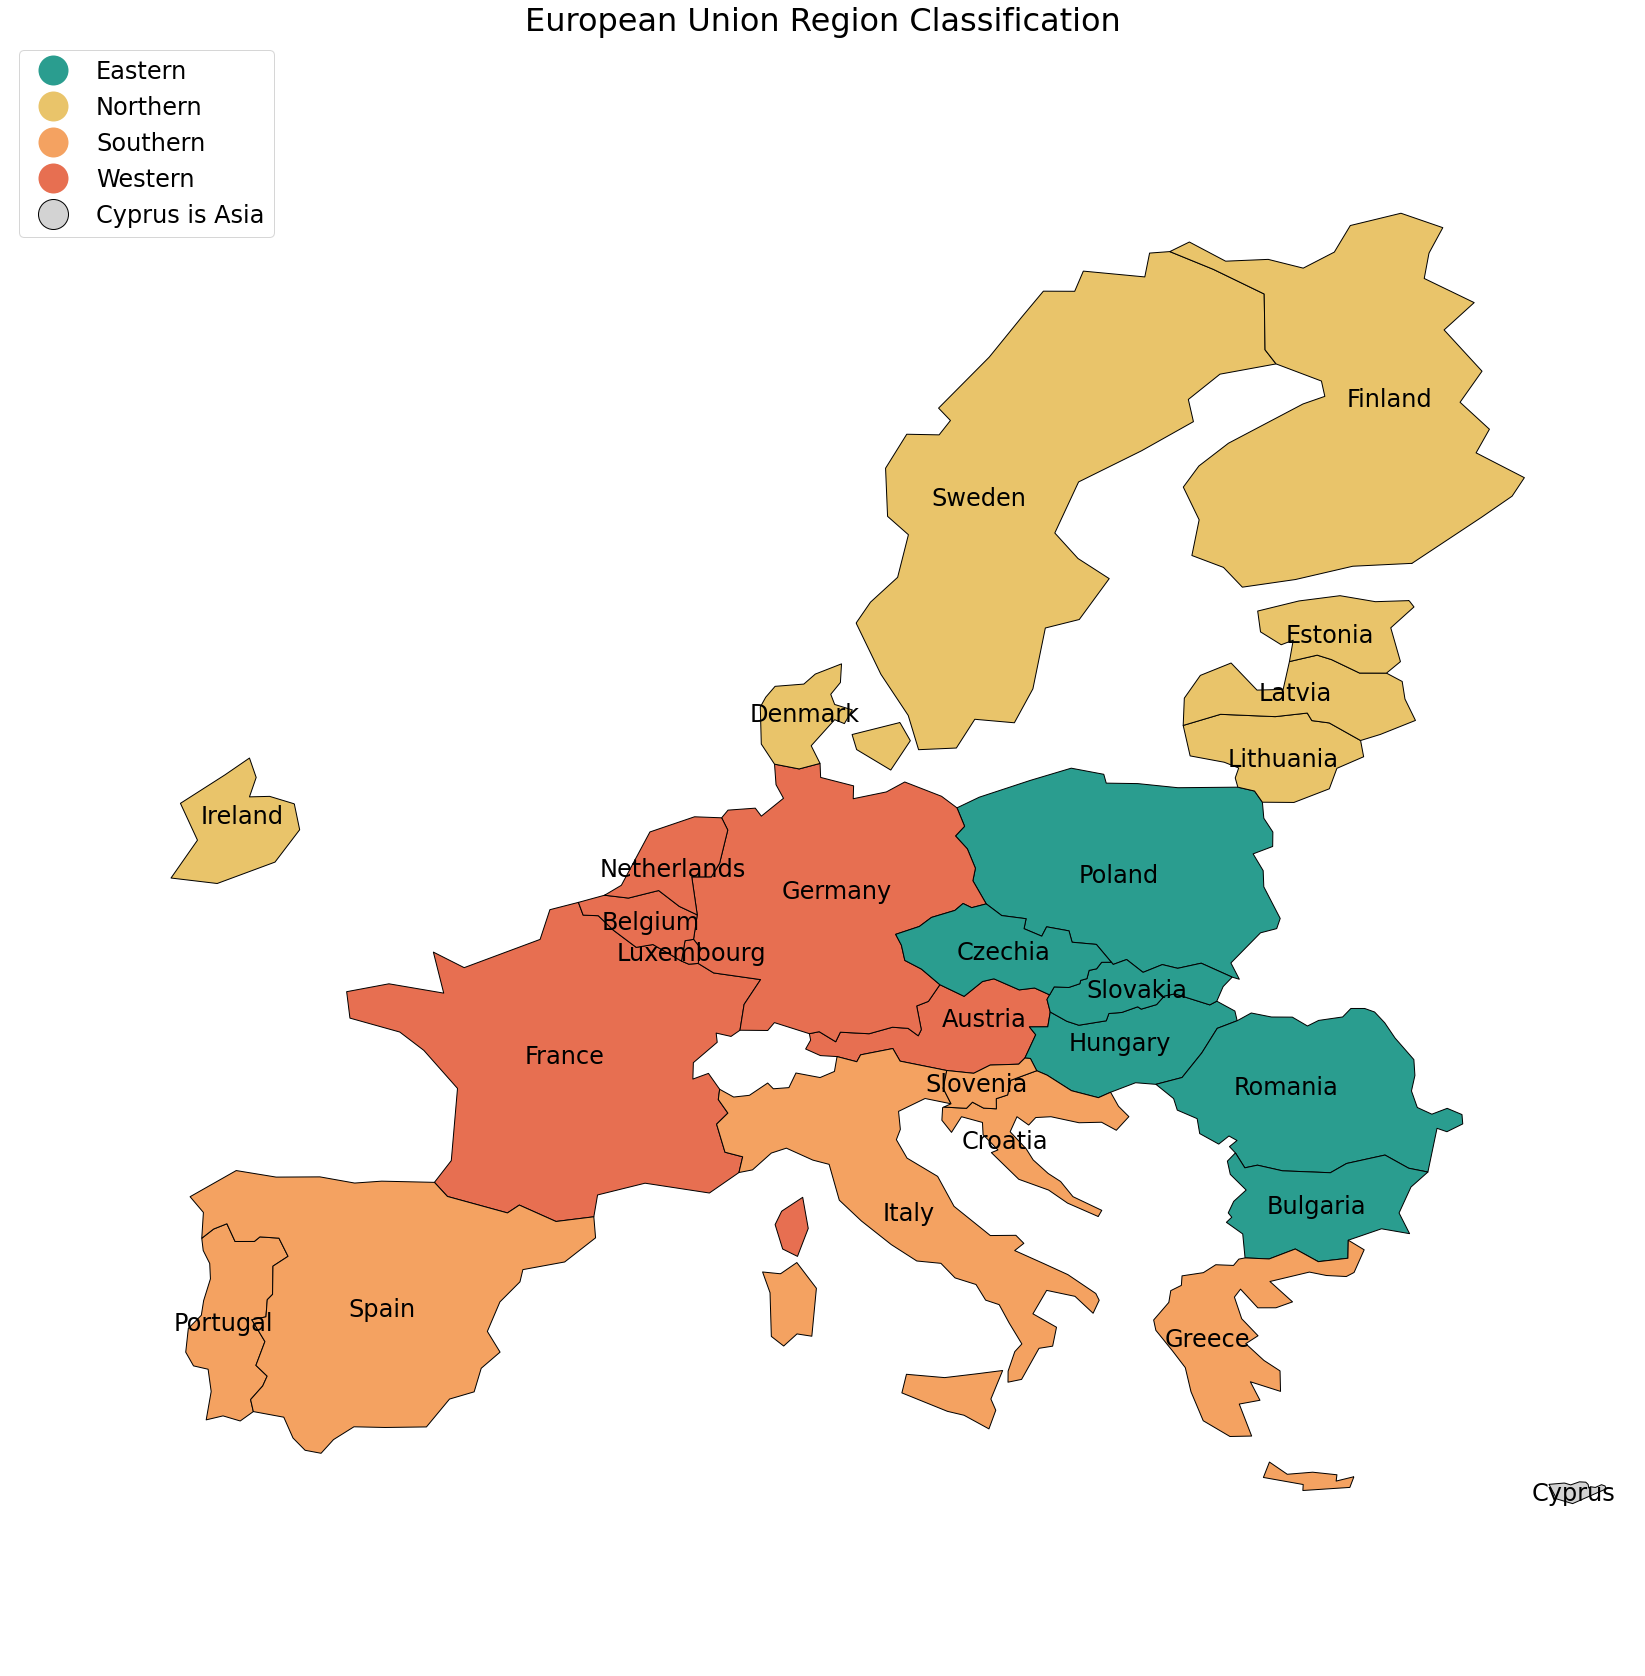

In [20]:
map_decoration()

## 1 - Introduction to the Dataset

<a id='R1.1'></a>
### 1.1 Request Data from API
- In this API, they stored the **name of cities** in different languages, and we had to manually mark down all the correct capital cities used in API before requesting data.


- Instead of using functions in 'openaq', we requested data by the function **'requests'** straightforwardly. The reason was, functions from 'openaq' did not work well for some cases. For instance, some data in specific locations were not available in 'openaq' but accessible when using 'requests' directly. To obtain a stable output, hence we used 'requests' to request data.


- To overcome the problem raised by the **limitation of data** available from the api, we requested data one-by-one from every available locations. There was more than one location in each capital city, and we combined all of them to gain the full data frame needed.
    
    
- When requesting data, we stored crucial information like times, types of pollutants, and countries, in CSV files as **Keys**, which were frequently used in functions created afterwards.


- We **removed negative** values since it was unreasonable to have a value of pollutants less than 0.


- According to the variable Datetime provided, we added new variables of **Data**, **Week**, **Month**, and **Year**, to prepare for taking averages in different time dimensions.

<a id='R1.2'></a>
###  1.2 Getting Average
- We worked on yearly, monthly, weekly, daily, and hourly average values in the following analysis, as such we established a helpful function, **get_data**, to generate means based on location and dimension of time. 


- With this function, for data points with unavailable data, we could **assign NANs** to them. With NANs assigned, plottings will not skip the missing data points.


- The last advantage of this function was, it could also **return coordinates** of the given area.

----------------------------------------------------------------------------------------------------------------------------------------
- After all the preparations, the data frame **df** stored the whole data set we used for analysis. The following table showed 20 rows from df in a table (the first 10 rows of **SO<sub>2</sub>** and the first 10 rows of **NO<sub>2</sub>**). 

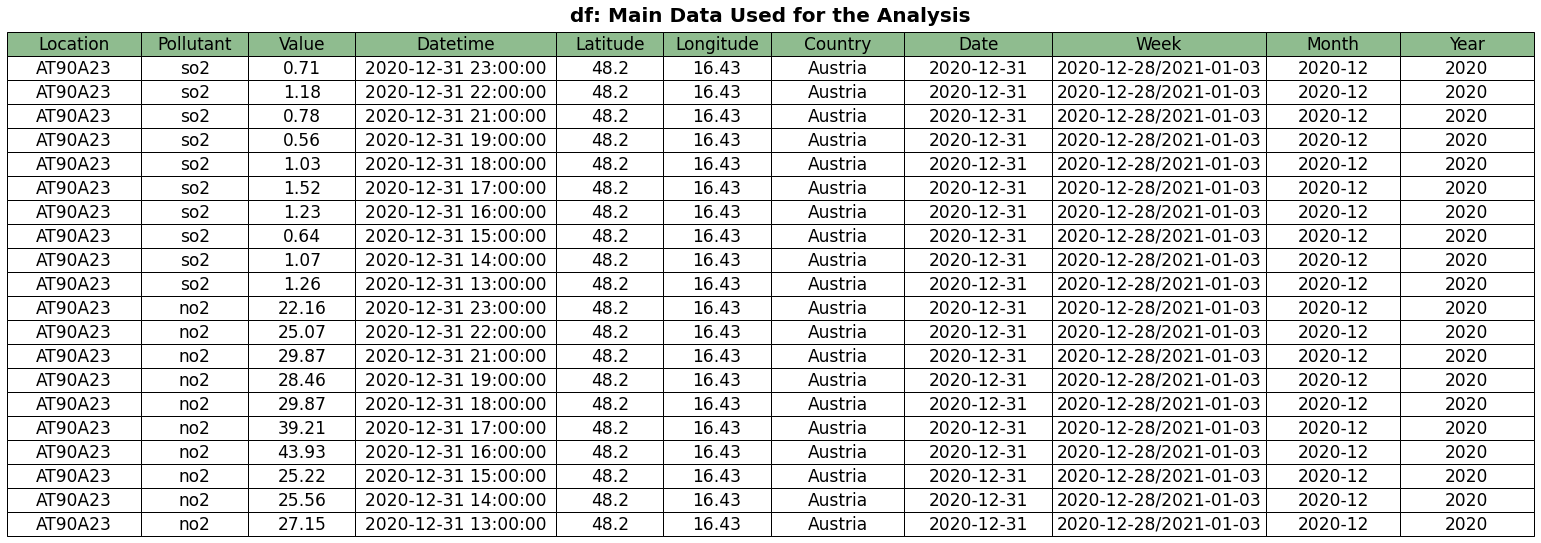

In [21]:
table(df, 'df: Main Data Used for the Analysis', n_row = 20)

<a id='R1.3'></a>
### 1.3 Data Availability

#### Background:
Data availability is essential in producing reliable conclusion for later analysis. By knowing when the first time pollutant's measurement was available, we can investigate further which country has started collecting the data late, or even has not started yet.



#### Explanation:
- This part of analysis only focuses on the first month when the countries started to gather the pollutant's data to get the overview of the data availability. 

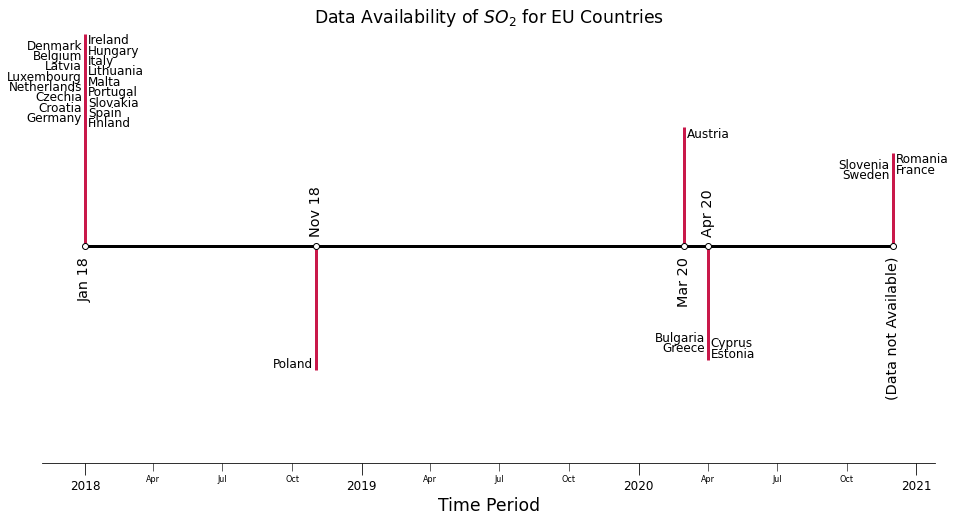

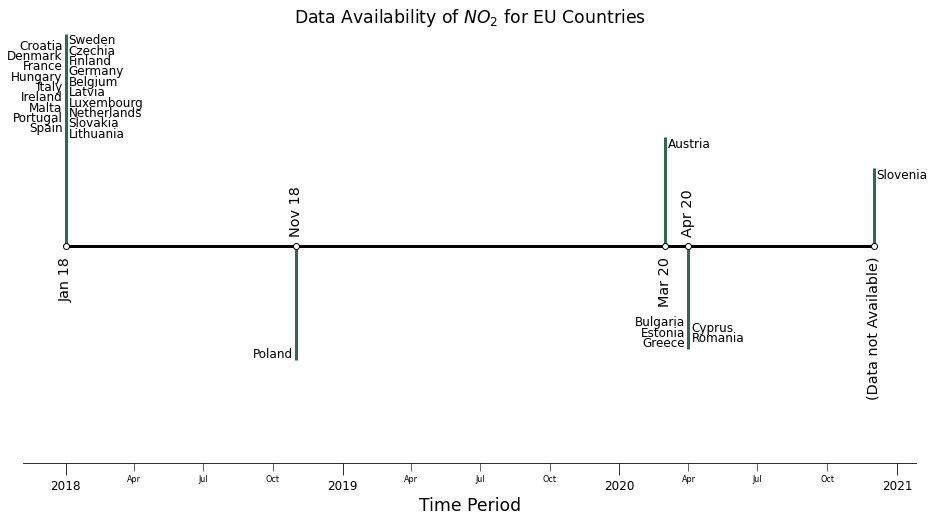

In [22]:
plot_data_availability()

#### Conclusion:
From the graph above, more countries have not even started collecting the data for **SO<sub>2</sub>** at the start of January 2018 rather than that of **NO<sub>2</sub>**, and these countries are mostly the same for both pollutants.

In details:
- **10** countries hadn't started collecting the data for **SO<sub>2</sub>** at the start of January 2018, and end up with **4** countries that had no data at the end of December 2020. On the other hands, only **8** countries had not started collecting the data for **NO<sub>2</sub>** at the beginning, and there is only **a single** country had no data at the end.
- **Slovenia**, is the only country that did not collect the data for both pollutants until the end. Whereas, **Romania**, **Sweden**, and **France** did not collect the **SO<sub>2</sub>** data only.
- Countries that started to collect the data of both pollutants late are **Poland**, **Austria**, **Bulgaria**, **Greece**, **Estonia**, **Cyprus**, and **Romania** (Only for **NO<sub>2</sub>**).

<a id='R1.4'></a>
### 1.4 Relationship between Pollutants

#### Background:
Acid rain is mainly caused by **SO<sub>2</sub>** and **NO<sub>2</sub>**, therefore we want to analyse the relationship between this two different pollutants in order to give a convinicinig advice to the related environmental protection institution. Therefore, the relationship will be analysed in this part, we can control one of them to make the purpose of controlling the another one if they have a strong correlation, otherwise, we should do the adjustment to both of the pollutants.

#### Explanation:
* Use **scatter plots** to show that the relationship between the two pollutants, and we computed the **Pearson Correlation Coefficient** to see the extent of the the relationship. 
* Monthly data in 3 years are used to create the scatter plot. The reason that we choose these data is because the number of observations of yearly data is too small, and daily data or hourly data is too big so that they cannot create a very clean and observable relation.

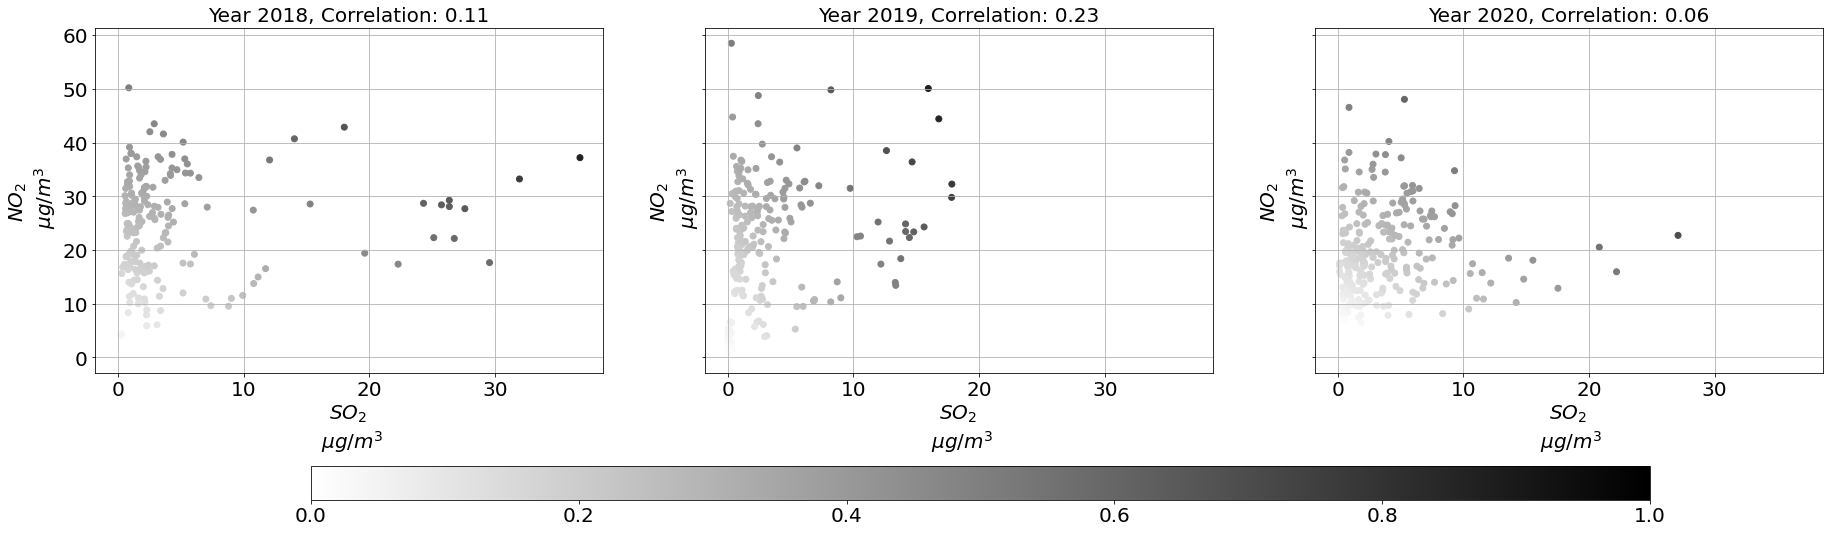

In [23]:
Relationship_Pollutant()

#### Conclusions:
From the scatter plot, we can see that the points are quite dispersed and it does not show us neither correlation nor any relation between **SO<sub>2</sub>** and **NO<sub>2</sub>**. Therefore, one does not cause another. The correlation coefficients are also showing that they do not correlate with each other.

## 2 - Extent of the Violation on Pollutant Concentration

Maintaining pollutant concentration below certain limit is not an easy task for countries, it is not even easier for countries that have already been treating the pollutants.

There are some reasons for this:
1. Based on European Environment Agency (EEA), the European Union (EU) sets 3 kinds of limits that EU countries need to follow. Those are
    - The Yearly Limit : Not exceed $20\mu g/m^3$ for **SO<sub>2</sub>** and $40\mu g/m^3$ for **NO<sub>2</sub>**
    - The Daily Limit  : Not exceed $125\mu g/m^3$ more than **3** times for **SO<sub>2</sub>**
    - The Hourly Limit : Not exceed $350\mu g/m^3$ more than **24** times for **SO<sub>2</sub>** and $200\mu g/m^3$ more than **18** times for **NO<sub>2</sub>**.
    
2. Even if the countries generally have been maintaining the value below those limit, some locations or areas inside the countries might have not been succeeded in doing so.

Therefore, every country has to look the pollutants in a different time ranges and in a different locations, creating a complex judgment about whether a country has been succesfully handling the pollutants until now or not. 

This analysis covers how does each country policies, which are assumed to be reflected in the data, succesfully treating **SO<sub>2</sub>** and **NO<sub>2</sub>** concentration in the air.


**Source**:
- [EEA-Nitrogen Dioxide Annual & Hourly Limit Values](https://www.eea.europa.eu/data-and-maps/figures/nitrogen-dioxide-annual-limit-values-for-the-protection-of-human-health)
- [EEA-Sulphur Dioxide Annual Limit Values](https://www.eea.europa.eu/data-and-maps/figures/sulphur-dioxide-annual-limit-value-for-the-protection-of-ecosystems)
- [EEA-Sulphur Dioxide Daily & Hourly Limit Values](https://www.eea.europa.eu/data-and-maps/figures/sulphur-dioxide-hourly-limit-value-for-the-protection-of-human-health-6)

Accesed on 23 November 2021

<a id='R2.1'></a>
### 2.1 Overview & Time Evaluation

#### Background:
Observing the concentration of the pollutants from time to time is crucial to evaluate how successful is the implementation of the policies in the EU countries. In this section, a map, which consists of EU countries, is shown from year to year for getting a general overview about the level of pollutant in these countries.

#### Explanation:
- Average yearly concentration over all of the locations in a given country is used for this analysis.
- A total of **6** maps will be generated for every year and every pollutant.

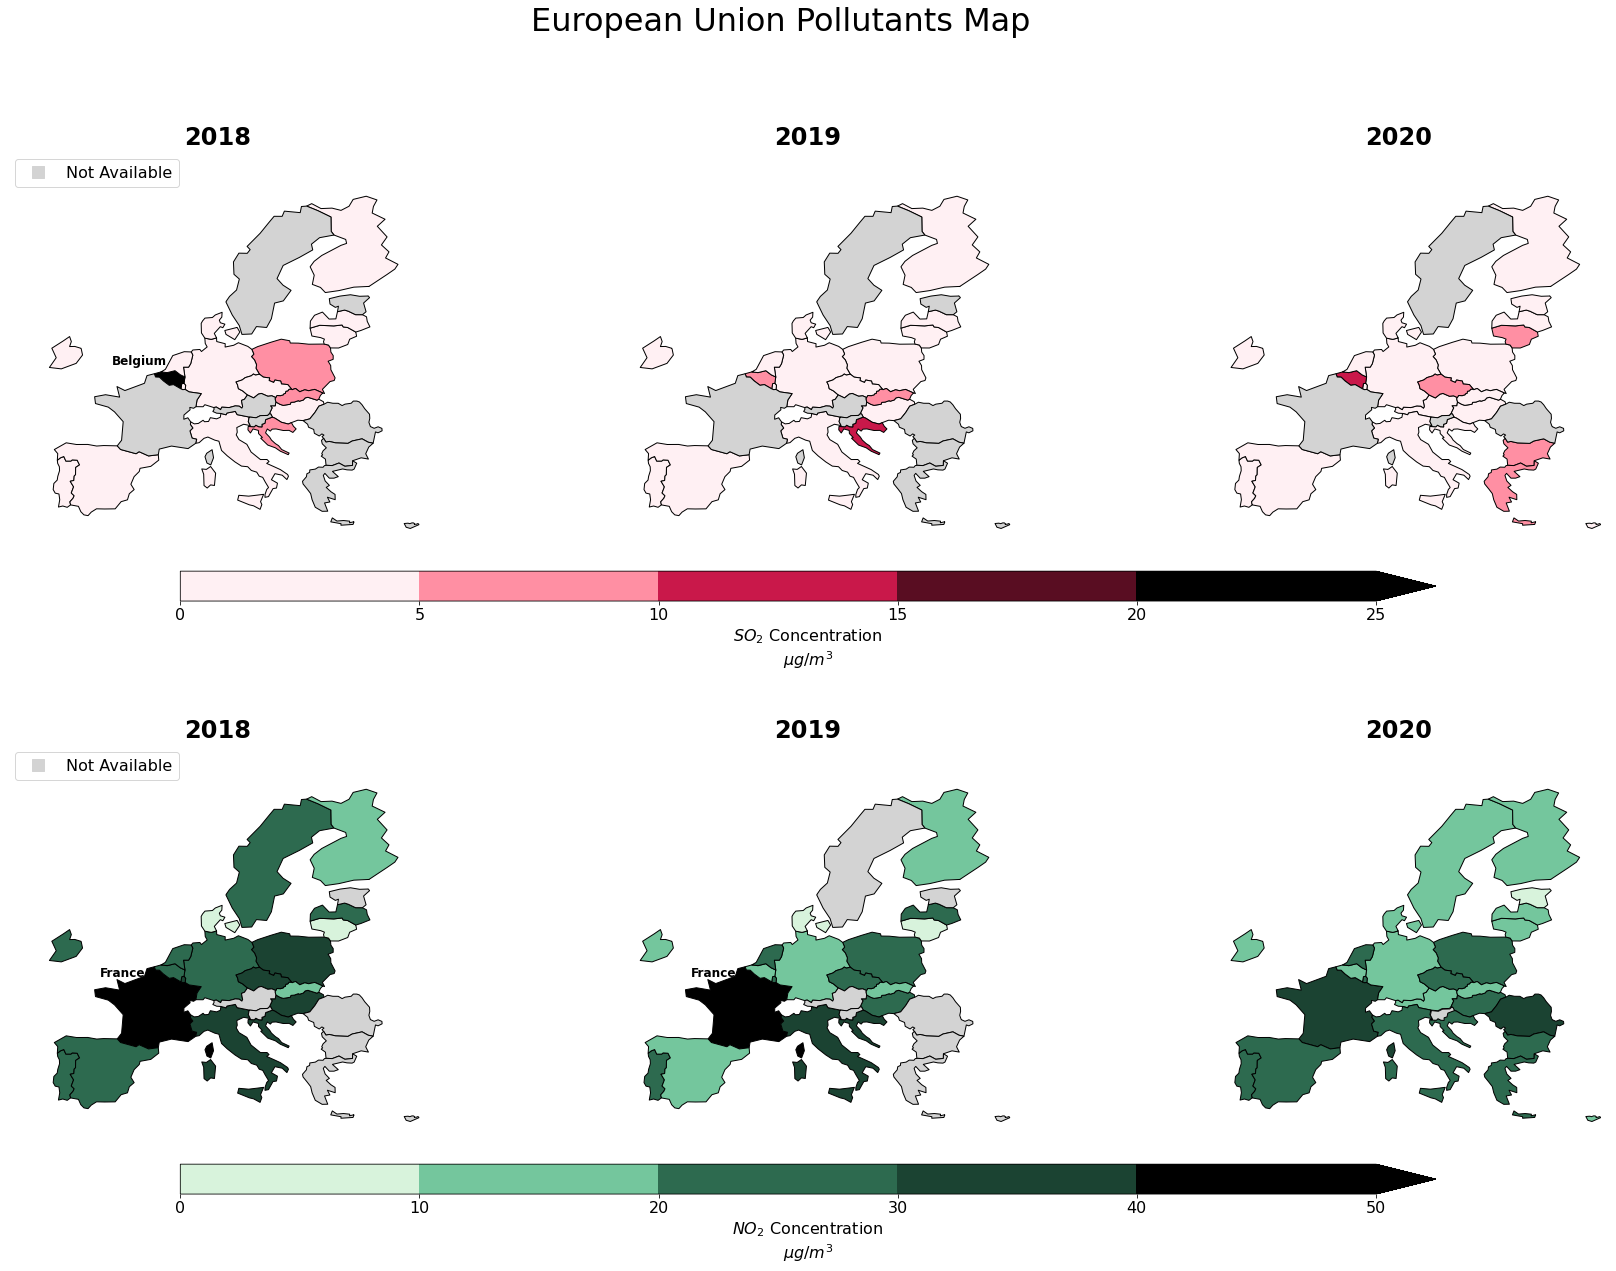

In [24]:
plot_map()

#### Conclusions:
Overall, the air pollutant of **SO<sub>2</sub>** in EU countries is not as dangerous as that of **NO<sub>2</sub>** when comparing it using the same scale with the yearly concentration limit.

In details:
- Since each country changes differently from year to year, there are no enough evidances to say that EU countries generally are getting better in handling **SO<sub>2</sub>** and **NO<sub>2</sub>** from 2018 and 2020.
- From the Graph, **Belgium** is the only country that surprasses the yearly limit of **SO<sub>2</sub>** and it happened in 2018. Whereas for **NO<sub>2</sub>**, **France** is the only country that exceeds the yearly limit and it happened twice in 2018 and 2019.
- Even though Eastern European countries did not exceed the yearly limit of **SO<sub>2</sub>** concentration, they have a worse **SO<sub>2</sub>** concentration compared to other EU countries.

<a id='R2.2'></a>
### 2.2 Changes Over Time

#### Background:
Before digging into details, we would like to gain a general idea of the changes of **SO<sub>2</sub>** and **NO<sub>2</sub>** in these 27 EU countries. Here, we generated plots of monthly, weekly, and daily average values. 

#### Explanation:
- Monthly and Weekly plots
    - Apart from showing the changes in each country, we were also interested in the comparisons between them. But it was impossible to read the information if we put 27 countries in a single plot. So we split them into four groups and showed each group alternatively. With other countries in gray lines as the background, we can clearly distinguish and compare each country.
    
- Daily plots
    - Other than showing trends of changes, we would like to analyse cases of extreme days. To gain a clearer plot, instead of putting countries together, we created a function allowing us to call the daily averages of a given country.

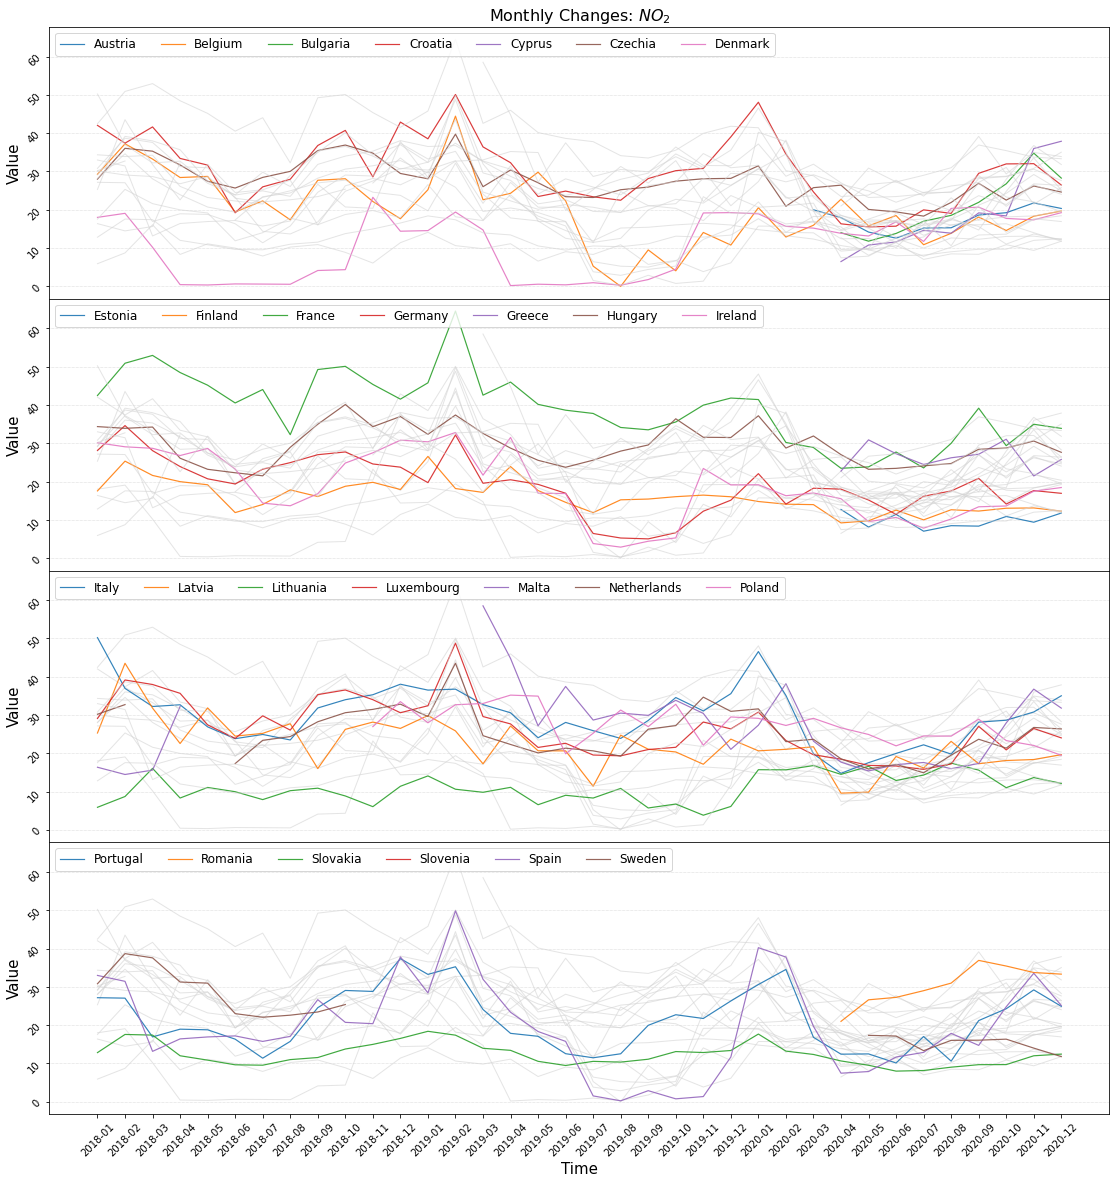

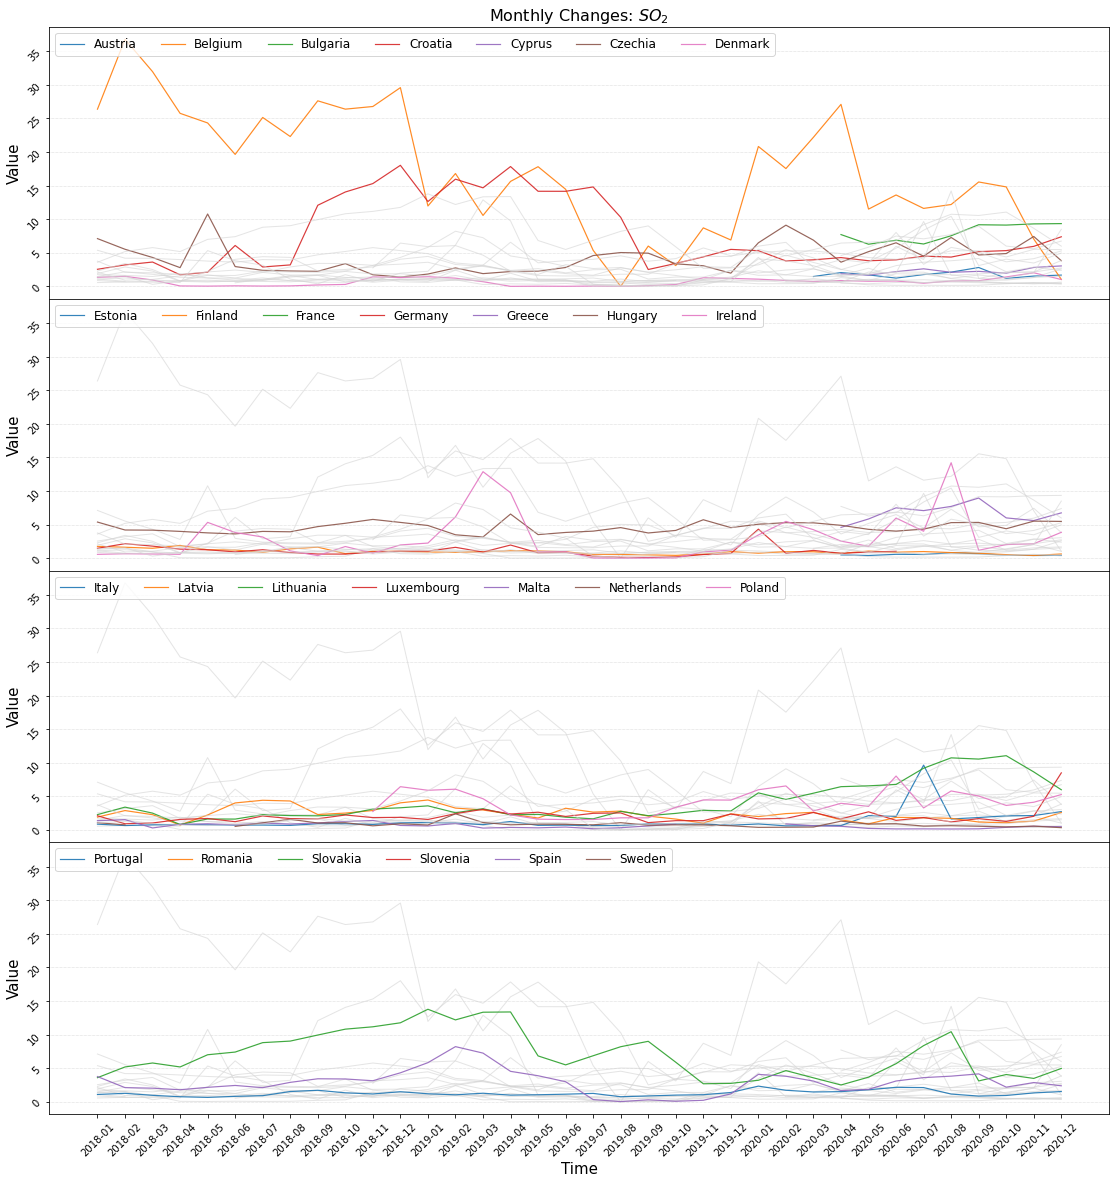

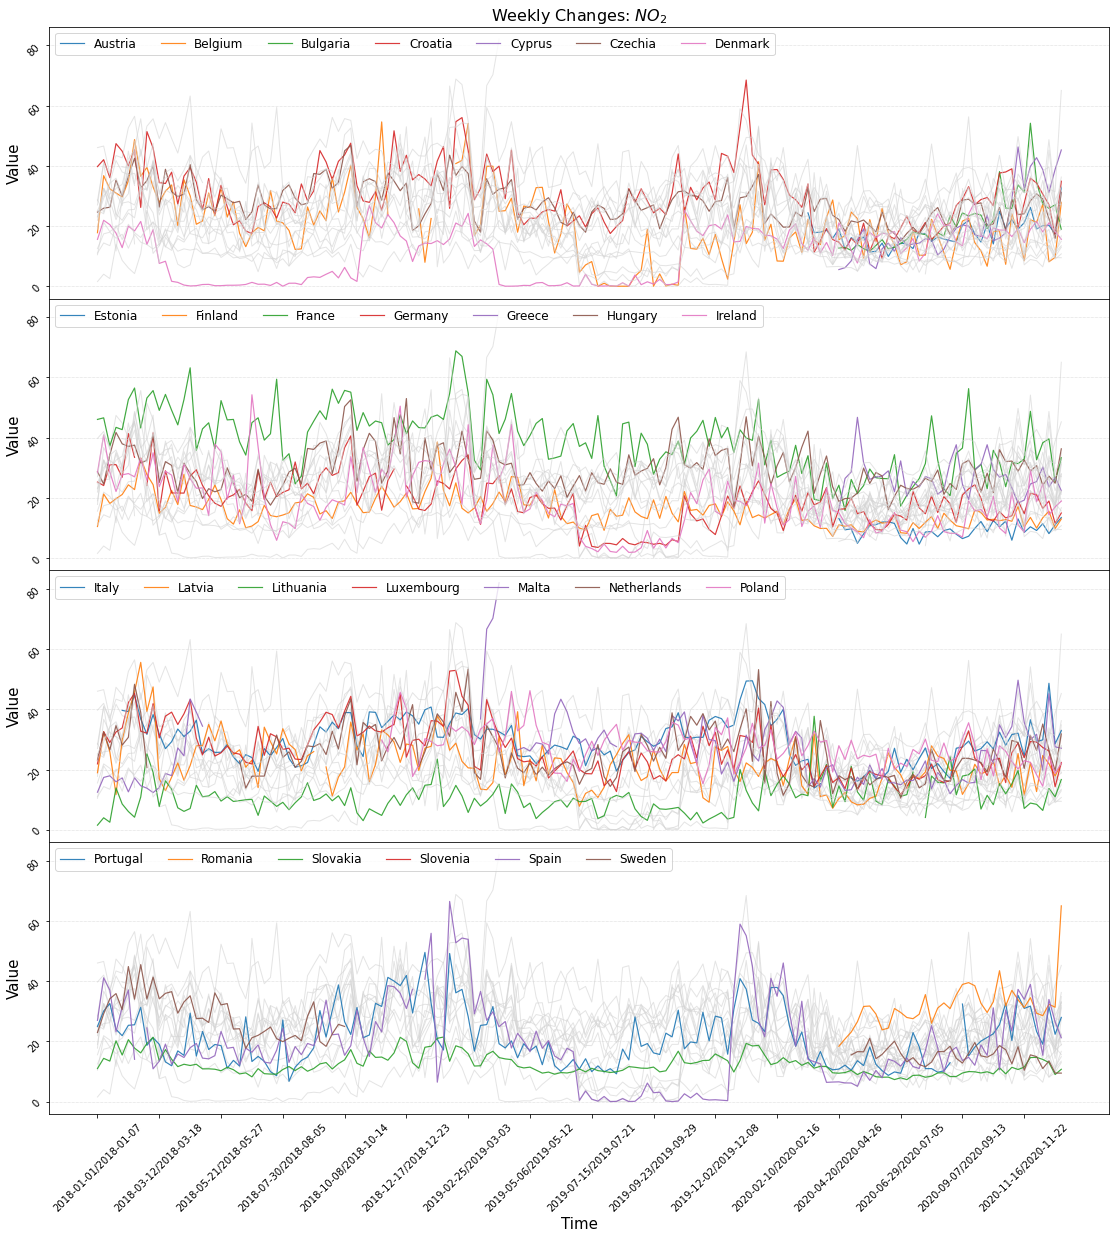

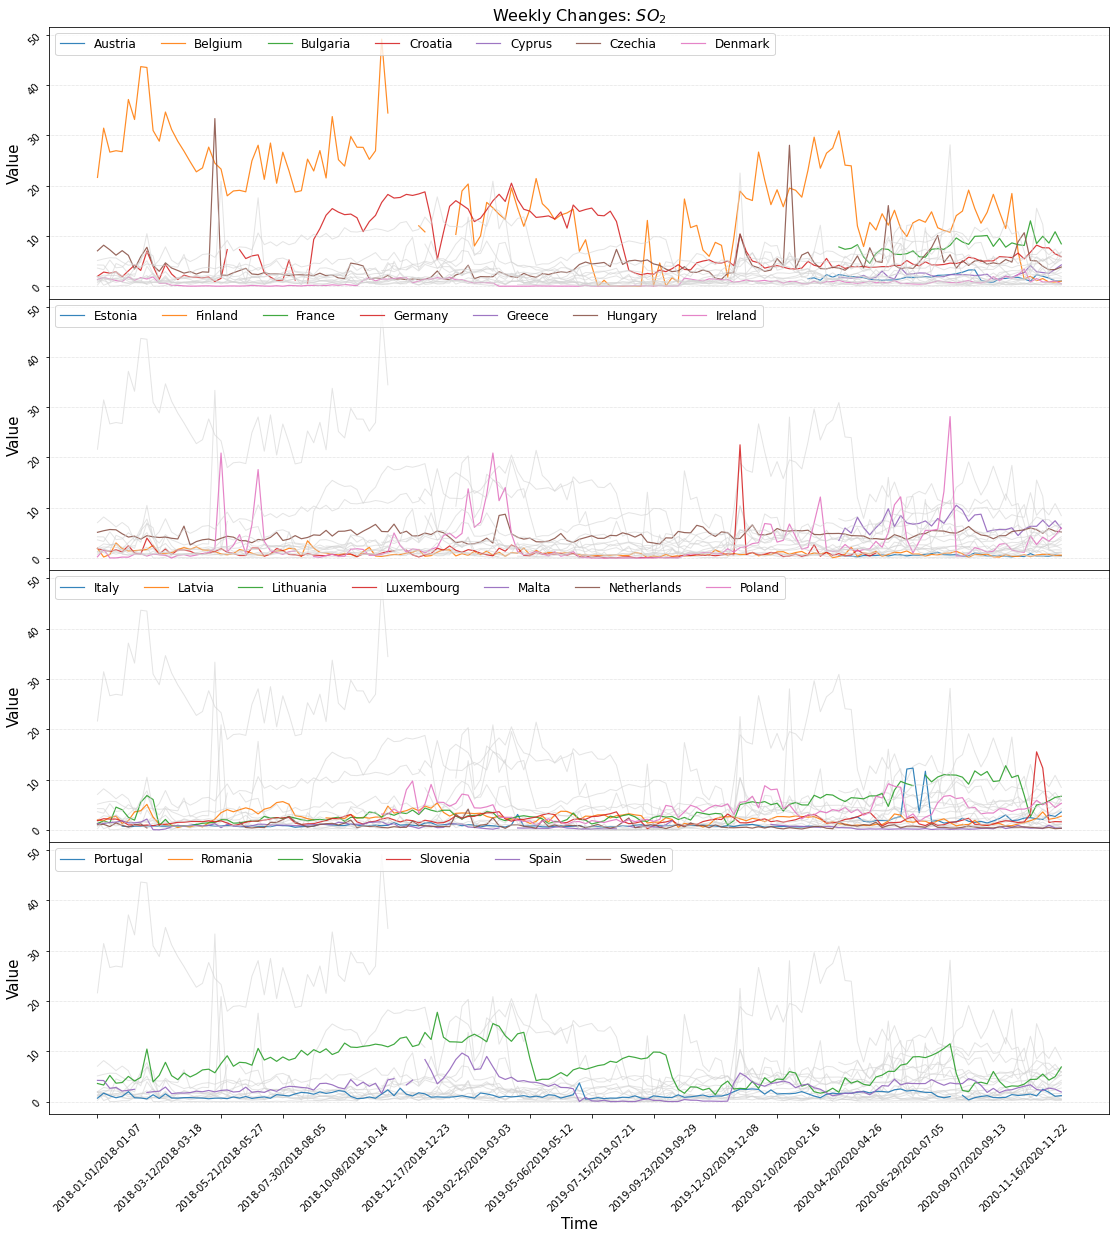

In [25]:
plot_27_MonthWeek(df, 'NO2', 'month') # monthly changes of NO2
plot_27_MonthWeek(df, 'SO2', 'month') # monthly changes of SO2
plot_27_MonthWeek(df, 'NO2', 'week') # weekly changes of NO2
plot_27_MonthWeek(df, 'SO2', 'week') # weekly changes of SO2

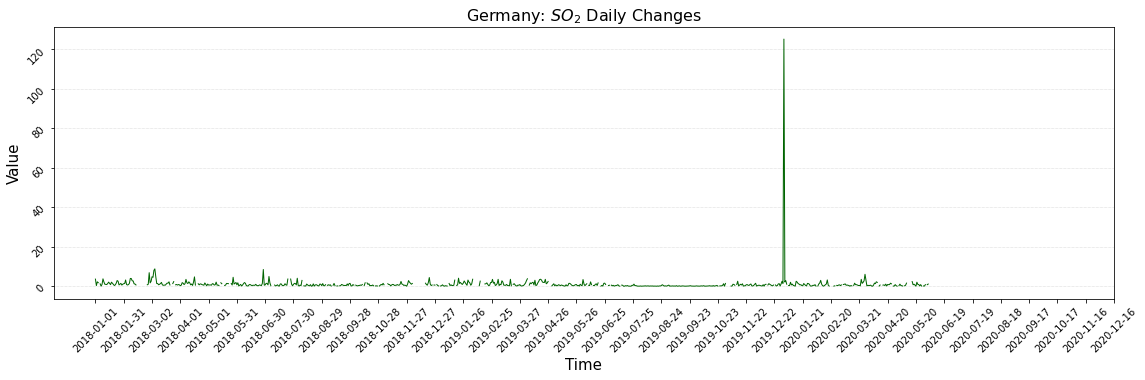

In [26]:
plot_daily(df, pollutant = 'SO2', country = 'Germany') # daily changes
# pollutant: 'SO2', 'NO2'
# country: 
# 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
# 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungaray', 'Ireland', 
# 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 
# 'Portugal','Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'

#### Conclusions:

Monthly & Weekly Plots:
- **Changes over time**:
    - During these 3 years, the mean values of **SO<sub>2</sub>** and **NO<sub>2</sub>** were relatively stable in all countries. We didn't observe any distinct trend of decrease or increase over time. For most countries, their values at the beginning are close to the values at the end within these three years.
   
   
- **Range of changes**:
    - According to monthly graphs, countries shared a similar range of changes, around 20, in terms of **NO<sub>2</sub>**.  By contrast, some specific countries, like Belgium and Croatia, obtained a wide range of changes over time, while many countries only involved a trivial difference of less than 10.
    - Further, from the weekly plots, the values of **NO<sub>2</sub>** fluctuated much in all countries, with some sudden surges or falls. The difference in weekly values of **SO<sub>2</sub>** was that, apart from the week with abrupt changes, the variations of values were very small in most countries. 
    
    
- **Best & Worst**:
    - In general, we can tell, France and Belgium are the countries with the worst situation in **NO<sub>2</sub>** and **SO<sub>2</sub>** respectively. Meanwhile, Denmark has the lowest values of both **NO<sub>2</sub>** and **SO<sub>2</sub>**.
    
Daily Plots:
- As shown from the daily plot for a country, like Germany, it is difficult to observe the concentration of pollutants with high volatility and the existance of extreme values on daily basis. Therefore, it will be better to observe it from the distribution without ignoring the extremness.

<a id='R2.3'></a>
### 2.3 Daily Observation

#### Background:
It is possible to have a country that violates the yearly limit but not the daily limit, vice versa. Therefore, having an in-depth analysis of the level of pollutant on daily basis is also necessary. Also, this part of analysis will also show the distribution to analyse not only the daily average, but also the volatility.

#### Explanation:
* Average daily concentration is used over all of the locations in a given country.
* Median is used as it is better for representing the center of skewed distribution.
* A distribution plot is generated by using the scatter plot to easily grasp the range of daily concentration of pollutant, to notice the extreme values that exceed the daily limit, and to compare the distribution with other countries. 
* Median is also used in this plot as it pictures the center of the distribution accurately when the data is skewed.
* The histograms are plotted to show the distribution of the concentration of **SO<sub>2</sub>** and **NO<sub>2</sub>** based on the areas in the Europe.

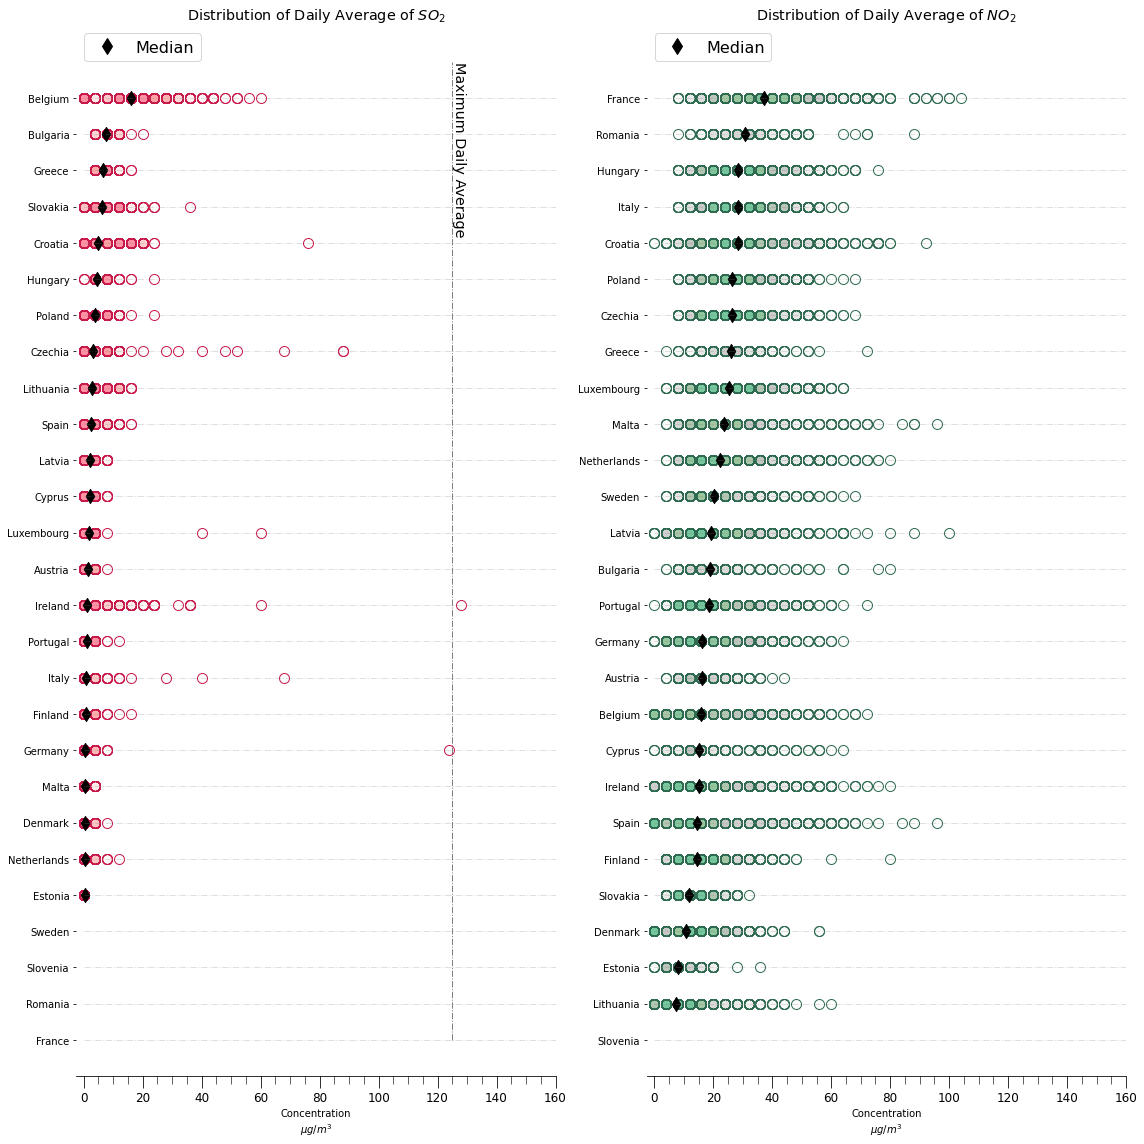

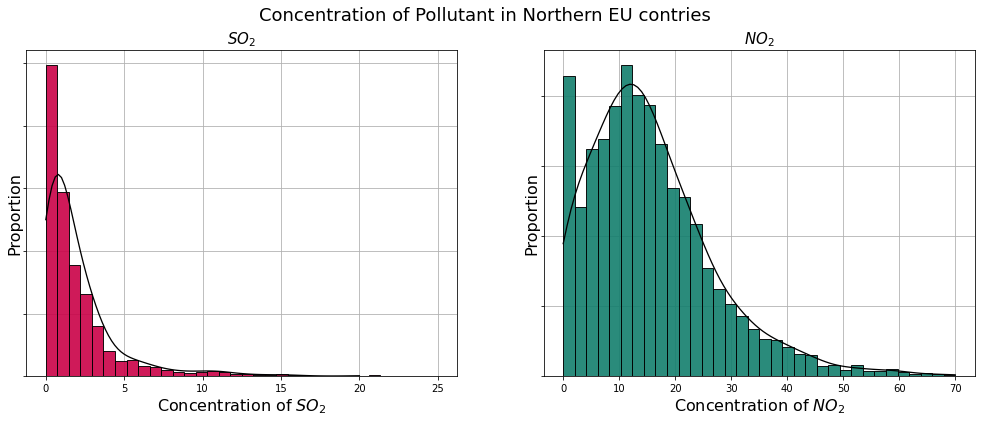

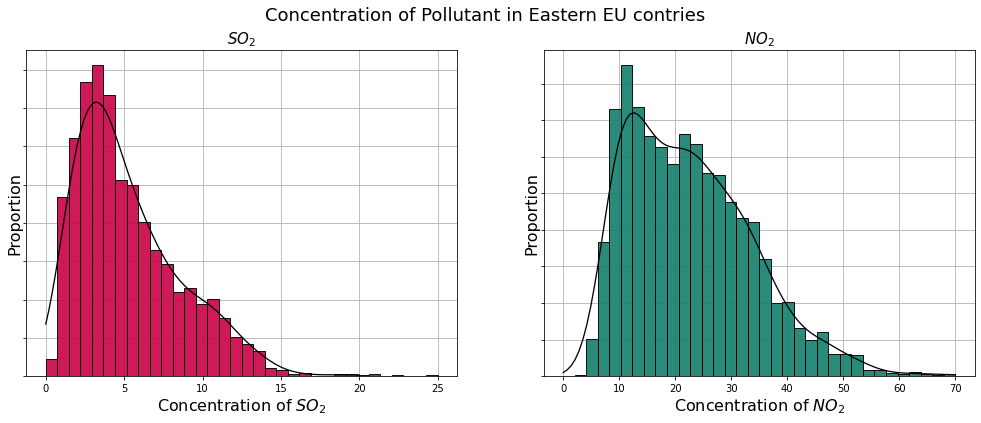

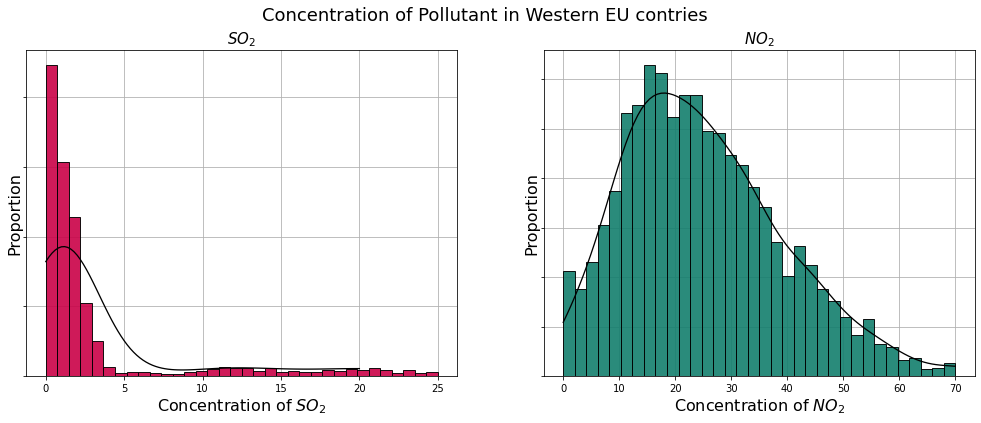

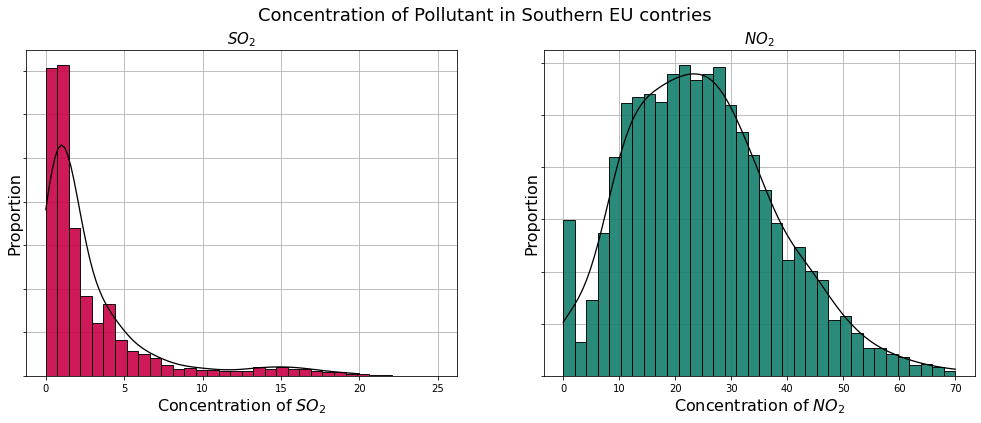

In [27]:
plot_distribution()
Distribution(area='All') 
# area = 'Northern', 'Eastern', 'Western', 'Southern' or 'All'

#### Conclusions:
**SO<sub>2</sub>** daily distributions are heavily skewed to the right with heavy tail, which means the majority of the observations showing that the air have low level of **SO<sub>2</sub>** concentration, but the extreme observations or days when the air is not safe are likely to happen.

In details:
1. Even though Belgium is the only country that violates the limit of **SO<sub>2</sub>** when it is observed yearly, the daily distributions of Belgium show that the daily level of **SO<sub>2</sub>** are manageble.
2. Ireland is the only country that surprasses the limit of **SO<sub>2</sub>** based on the daily observation. On the other hand, Germany barely reaches the limit. Importantly, both of them are not violating the daily limit from EU as they have less than 3 observations that exceed $125\mu g/m^3$.
3. Despite having a higher concentration and more volatile, **NO<sub>2</sub>** daily distribution does not have a heavy tail as **SO<sub>2</sub>**. It means that the daily extreme observations are almost impossible to happen. On the other hands, **SO<sub>2</sub>**, especially in Western Europe has some extreme values for the measurement.
4. The overall worst emission is happening in Eastern Europe.
5. **NO<sub>2</sub>** seems having a symmetrical distribution, but it also has a big proportion for the emission test of 0. Therefore, it is worth to doubt that the error of measuring the pollutants is existing.

<a id='R2.4'></a>
### 2.4 Estimating the Extreme

#### Background:
Hourly measurement of pollutants' concentration is very much different from both daily and yearly measurements. This is because the concentration can be really high in one hour but quickly reduce in just several hours. Moreover, the level of extremeness of concentration in hourly measurement cannot be compared with both daily and yearly measurements, therefore, it creates a right-skewed distribution with heavy tail for some cases. 

#### Explanation:
* Average hourly concentration is used over all of the locations in a given country.
* Median is used as it is better for representing the center of skewed distribution.
* Kernel Density Estimation (KDE) are used to estimate the probability that a country will exceed the hourly limit, while maintaining to show the distribution of the data. Additionally, this approach will create an awareness not only towards the center of the distribution and the deviation from the center, but also how extreme the values can vary among the distributions with the same center and deviation. 
* Since the value of measurements is assumed to be positive, the probability that a country will exceed the hourly limit will be adjusted by calculating the conditional probability given the measurement is positive.

#### Kernel Density Estimation (KDE):

Is a method to estimate the probability density function by placing a function called kernel on all observation points, and estimates the distribution using the sum of all kernels.

In this analysis, the choice of standard normal distribution is chosen as the kernel,
<h4><center>
$$K(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}.$$
</center></h4>
Let $(x_1, x_2, ..., x_n)$ be any observations from a random  variable $\textbf{X}$ which will have the density function estimated
$\newline$
and "to place the kernel on an observation" ($x_i$ for example) means changing the kernel into
<h4><center>
$$K(x)\rightarrow \frac{1}{h}K\left(\frac{x-x_i}{h}\right),$$
</center></h4>
where $h$ denotes the bandwidth parameter, deciding the smoothness of density estimation or the sensitivity of the  estimation.
Thus, the kernel density estimation for $\textbf{X}$ is
<h4><center>
$$f(x)=\frac{1}{n}\sum\limits^{n}_{i=1}{\frac{1}{h}K\left(\frac{x-x_i}{h}\right)}.$$
</center></h4>

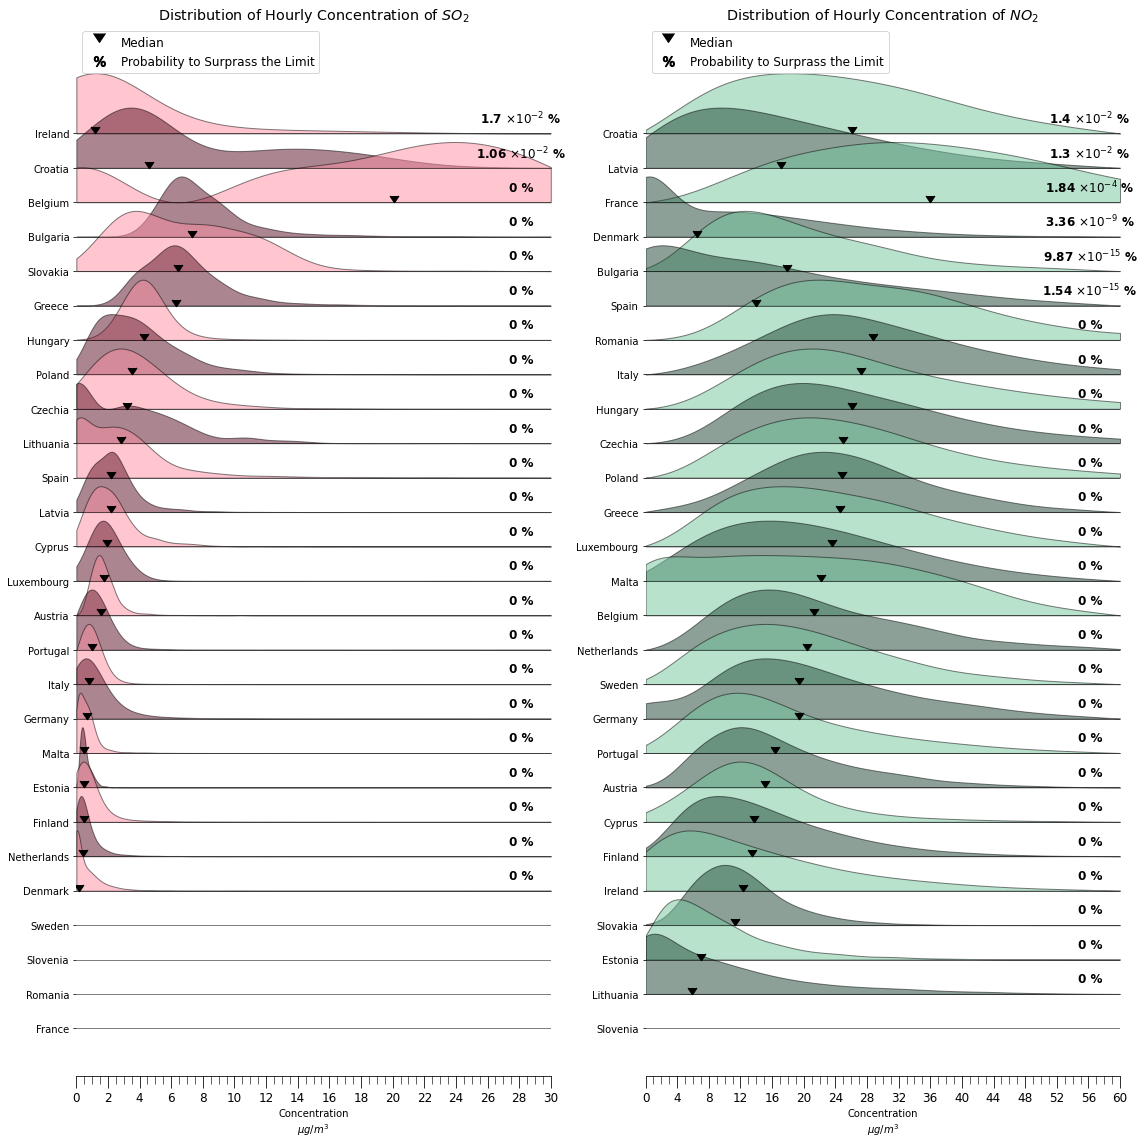

In [28]:
plot_distribution_kde()

#### Conclusions:
Overall, the probability that a country will exceed the hourly limit is almost negligible for both pollutants, meaning all countries are far from violating the hourly limit.

In details:
- Croatia has high probability to exceed the hourly limit for both pollutants, which are **1.06%** for **SO<sub>2</sub>** and **1.4%** for **NO<sub>2</sub>**. This characteristic does not show up at the yearly and daily analysis.
-  Assuming binomial distribution to calculate the probability that in 1 year, the countries will exceed the limit more than **24** times for **SO<sub>2</sub>** or **18** times for **NO<sub>2</sub>**, not a single countries has the chance to violate the hourly rule.

<a id='R2.5'></a>
### 2.5 How the Pollutants Spread around the Capital City

#### Background:
One of the limitation in this analysis is that the capital city of a country may not reflects the overall pollutant in a country. This section will take an estimation of pollutants level around the capital city to get a better understanding how the pollutants spread around that area.


#### Explanation:
- Both yearly location and yearly country's average data are used along with the longitude and latitude columns.
- A total of **6** maps will show how the pollutant sread around the capital city, they are generated from every year and every pollutant. 
- **2D Kernel Density Estimation** is used to model the spreadness, and it is adjusted with the concentration level in each location.

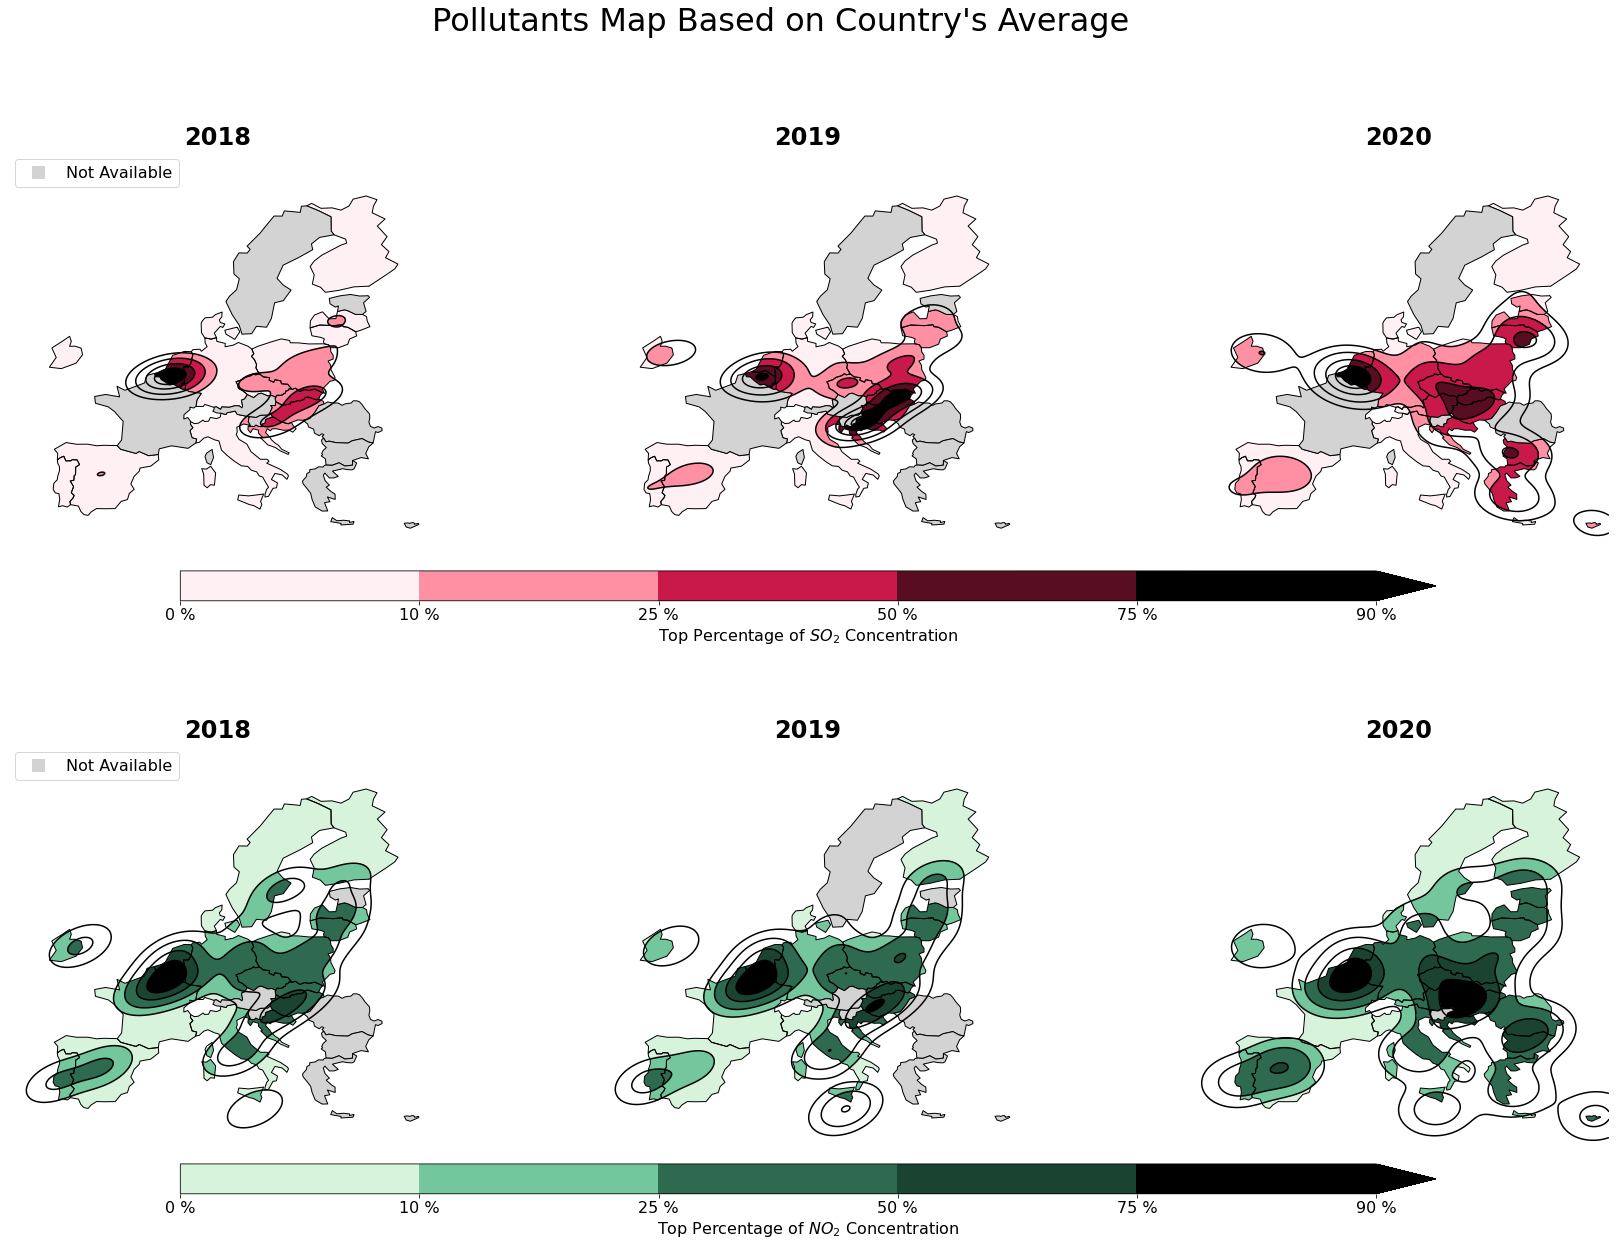

In [ ]:
plot_map_kde('country')
plot_map_kde('location')

#### Conclusions:
Overall, Regions near the border of Belgium and France are having the worst concentration of pollutants. However, when the analysis using the location data, Spain shows it has a really high concentration at that area, especially for **NO<sub>2</sub>**. Therefore, this concludes that not all countries perform the same when analysis based on each location instead of country's average.

In details:
1. Northern Europe is generally having low level concentration of pollutants even after comparing it using location data.
2. Ireland is one of the country that performs better than other countries when the data is analysed by using the location data.

<a id='R2.6'></a>
### 2.6 In-details Report of Location Data

#### Background:
As reported before, one country can be shown to perform really well on handling the pollutant by using the country's average data on daily basis, but it performs worse on yearly location's data. Therefore, this section will focus on creating a report about all of the countries' violation towards EEA rule in all possible scenarios.


#### Explanation:
- The reports consist of yearly violation, daily violation, and hourly violation in every location in all EU countries over a period of 2018-2020.

However, there will be an adjustment to create a fair assessment:
1. **Missing Value**: Since some locations have missing data in the given period, thus the number of violation will be adjusted.
For example: In daily observations, the average concentration of a country exceeds the limit 3 times. However, since the observations are available only for 100 days instead of 365 days, then the number violation will be increased **proportionally** to $3 \times 365/100 = 10.95$.

2. **Percentage of Violation per Year**: Instead of showing average yearly, daily, and hourly violation per year, the average will be divided by the maximum number allowed to exceed the limit value.
For example: If a country exceed $125\mu g/m^3$ for daily **SO<sub>2</sub>** concentration 3 times per year, then since based on EEA the maximum number allowed to exceed the daily limit value is 3, then the percentage of violation for daily observations for that country is 100%.

Additionally, to make the report structured, it will be presented with the country having the worst location at the first position. 


In [ ]:
so2_result, no2_result = create_report()
table(so2_result, '$SO_2$ Violation Report in 2018-2020')
table(no2_result, '$NO_2$ Violation Report in 2018-2020', n_row=100)

#### Conclusions:
The reports above supporting the previous analysis quantitatively, presenting the better information about the locations that need extra help to reduce the pollutant at those areas.

In details:
- It is harder to maintain **NO<sub>2</sub>** concentration below certain limit based on 69 (out of 273 locations) different locations that at least once has exceeded the limit, compared to only 17 (out of 85 locations) different locations for **SO<sub>2</sub>**.
- The reason why Ireland performs better for **NO<sub>2</sub>** when observed with locations data is that no location under Ireland is reported in **NO<sub>2</sub>** violation report, even Denmark, as one of the best country in handling **NO<sub>2</sub>**, has 3 locations that exceed the hourly limit. On the other hand, there are 2 locations under Ireland in **SO<sub>2</sub>** report, and that is the reason why Ireland is estimated to have a high extreme value probability for hourly concentration of **SO<sub>2</sub>**.
- Austria, Cyprus, and Estonia do not have any locations in these reports. However, those countries don't have any data before 2020, therefore, it is hard to conclude the overall performance of those countries based on 1 year observation.
- On the other sides, Malta is the only country that has data since 2018 and does not appear in the report. However, Malta only has 1 location representing the capital as well as representing the country.

<a id='R2.7'></a>
### 2.7 Conclusions

From the data analysis of both Sulphur Dioxide (**SO<sub>2</sub>**) and Nitrogen Dioxide (**NO<sub>2</sub>**) inside European Union in the period of 2018-2020, we conclude several important fact:

1. There is **no strong evidance** that either **SO<sub>2</sub>** or **NO<sub>2</sub>** concentration in air is **changing from time to time**.

2. However, based on the low number of countries that violate the rule stated from European Environment Agency, **European Union is still maintaining those pollutants concentration below specific limit**. Therefore, inline with the statement that acid rain is less occuring nowadays.

3. **East Region of European Union countries have the highest concentration of SO<sub>2</sub>** in air, while the other regions tell negligible different. Moreover, for **NO<sub>2</sub>**, almost all regions have similar efforts in handling the pollutant. 

4. Different time range, such as yearly observations and daily observations, to analyse the pollutants will result in a divergent conclusion. Moreover, analysis on **country's location shows that the concertation of pollutants has distinctive measurement from location to location**, although it is analysed in the same city.

5. All countries having full observation from 2018-2020 have atleast one location that exceeds the limit values of either pollutants, except for **Malta**.